In [1]:
# from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
import sys
import copy
#Quick fudge to make import from ../Scripts work
import sys
sys.path.append('/Users/floorbroekgaarden/Projects/BHNS_project/Scripts')
import string

import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data
import coencodeVarious        as CV
from PostProcessingScripts import * 
from ClassFormationChannels_5mainchannels import * 


import pandas as pd


from astropy import units as u
from astropy import constants as const


In [2]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def plotdesigndistributionModels(axe=None, dfkey='mass1', BPSmodelNames=['A'], MSSFRmodelNames=['000'], DCOtype='BHNS', xvarrange=None, xlabel='xlabel', ylabel='ylabel', \
                              xlim=[1,30], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=['A'], whichMSSFRcolor=['000']): 
    """ 
    plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    whichWeight = 'intrinsic' 'observed'
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    """
    
#     BPScolors = sns.color_palette("husl", len(xvarDCO)) 
    BPScolors = ['crimson', 'purple', 'mediumblue', 'cyan', 'teal', 'lime', 'gold', 'darkorange', 'orangered', 'red']
    lw = 3.5
    
    BPScolors       = sns.color_palette("husl", len(BPSmodelNames))
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
 
    
    if DCOtype=='BHNS':
        DCOname='BHNS'
    elif DCOtype=='BBH':
        DCOname='BHBH'
    elif DCOtype=='BNS':
        DCOname='NSNS'


    
    # path for files 
    path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'
    nModels=15
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]
    modelDirList = ['fiducial', 'massTransferEfficiencyFixed_0_25', 'massTransferEfficiencyFixed_0_5', 'massTransferEfficiencyFixed_0_75', \
                   'unstableCaseBB', 'alpha0_5', 'alpha2_0', 'fiducial', 'rapid', 'maxNSmass2_0', 'maxNSmass3_0', 'noPISN',  'ccSNkick_100km_s', 'ccSNkick_30km_s', 'noBHkick' ]

    alphabetDirDict =  {BPSnameslist[i]: modelDirList[i] for i in range(len(BPSnameslist))}



	#####




 
    
    
    
    
    
    for ind_m, BPSmodelName in enumerate(BPSmodelNames):
            if ind_m%15==0:
                print('now at m=', BPSmodelName)
            # read in model
            
            
            path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
            path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   
            
            fdata = h5.File(path)
#             df = pd.read_csv('CompactData_model_' + BPSmodelName + '_' + DCOtype + '.csv', header=[0], skiprows=[1])
            
            if dfkey in ['q', 'mchirp', 'mtot', 'massBH', 'massNS']:
            
                # obtain BH and NS masses
                xvar1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
                xvar2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
#                 xvar1 = df['mass1']
#                 xvar2 = df['mass2']
                M1, M2 = obtainM1BHandM2BHassymetric(m1=xvar1, m2=xvar2) # M1 will be the most massive, M2 the least massive compact object. 
                if dfkey =='mtot':
                    xvar=M1+M2
                elif dfkey=='massBH':
                    xvar = M1
                elif dfkey=='massNS':
                    xvar = M2                
                elif dfkey =='q':
                    xvar = M1/M2
                elif dfkey=='mchirp':
                    xvar = chirpmass(M1,M2)
                else:
                    print('KeyError')
                del M1
                del M2
                del xvar1
                del xvar2
                
            else:
                xvar = df[dfkey]
            
#             if dfkey=='tc':
#                 xvar = xvar/1000 # convert to Gyr 
            
            label = None
            
            if BPSmodelName in whichBPScolor:
                BPScolor = BPScolors[ind_m]
            else:
                BPScolor = 'gray'
            
            
            
            
            
            ii=0
            for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
                # read in MSSFR weights: 
                if whichWeight=='det':
                    # get detected weights
                    fparam_key = 'weights_detected'
#                     dfkey_w = mssfr+'_R_det'
                elif whichWeight=='z0':
                    # get intrinsic weights
                    fparam_key = 'weights_intrinsic'
#                     dfkey_w = mssfr+'_R_z0'

                weightheader = 'w_' + mssfr
                w = fdata[fparam_key][weightheader][...].squeeze()
#                 w = df[dfkey_w]
                

                if mssfr in whichMSSFRcolor:

                    if mssfr=='000':
                        MSSFRzorder = 100
                        MSSFRlinestyle = MSSFRlinestyles[0]
                        MSSFRalpha=1
                    elif mssfr=='231':
                        MSSFRzorder=50
                        MSSFRlinestyle = MSSFRlinestyles[1]
                        MSSFRalpha=1
                    elif mssfr=='312':
                        MSSFRzorder=51
                        MSSFRlinestyle = MSSFRlinestyles[2]
                        MSSFRalpha=1                    
                else:
                    BPScolor = BPScolors[ind_m] #'gray' 
                    MSSFRalpha=0.3
                    MSSFRlinestyle = '-'
                    MSSFRzorder=10

                # make the plot 
                if whichPlot=='cdf':
                    axe.hist(xvar, density=True, bins=len(xvar), cumulative=True,
                             histtype='step', alpha=MSSFRalpha, color=BPScolor, label=None,\
                             linewidth=2, linestyle=MSSFRlinestyle, zorder=MSSFRzorder, weights=w)
                    ii+=1
                        
                     
        
    # MAKE CDF background
#     y_quantiles = np.linspace(0.1,1,10)
#     x_quantiles = np.linspace(xlim[0], xlim[1], 10)
#     yy_0 = np.zeros_like(x_quantiles)

#     # COLOR MAP 
#     cm       = plt.get_cmap('Greys')
#     Nc = 10
#     greys = [cm(x) for x in np.linspace(0,1 , int(1.5*Nc))]  # I dont want the dark colors
    
#     ii = 0
#     for ind in range(Nc):
#         ii +=0.10
#         yy_q = np.ones_like(yy_0) * ii 
#         axe.fill_between(x_quantiles, yy_0, yy_q, facecolor=greys[ind], \
#                          alpha=1, zorder=1)#,\  
#         textt_q = r'$\,$' + str(np.round(ii*100., 1))  +'\%'
# #         axe.text(xlim[1], ii, s=textt_q, rotation = 0, \
# #                  fontsize = fs-10, color ='k', ha = 'left', va='center')#, weight = 'bold')
#         yy_0 = yy_q 

  
    del xvar
    del w
    ###########
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])
        

    axe == CV.layoutAxes(axe, nameX=xlabel, nameY=ylabel)
    

    
    if indplot==0: 
        handles, labels = axe.get_legend_handles_labels()
    else:
        handles, labels = None, None
        
#     axe.grid(True)
    
    
    return handles, labels
    

In [4]:
MSSFRnameslist = []
MSSFRnameslist.append('000') # add phenomenological 

for ind_GSMF, GSMF in enumerate(GSMFs):
    ind_y = ind_GSMF + 1
    for ind_MZ, MZ in enumerate(MZs):
        ind_z = ind_MZ +1
        for ind_SFR, SFR in enumerate(SFRs):
            ind_x = ind_SFR+1
            
            
            
            
        

            MSSFRnameslist.append('%s%s%s'%(ind_x, ind_y, ind_z))

print(MSSFRnameslist)

['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']


In [5]:

# MSSFRalphas = [1., 0.5, 0.5, 0.5]
# MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']



# TYPE = 'BHNS'
# whichWeight='det'
# nModels=15
# BPSnameslist = list(string.ascii_uppercase)[0:nModels]
# whichMSSFRcolor=['000', '231', '312']

# MSSFRnameslist = whichMSSFRcolor

# f, ax= plt.subplots(ncols=3,nrows=2,figsize=(26,14), 
#                   gridspec_kw={"width_ratios":[1.5, 1.5,1.5], "height_ratios":[2,2]})



# # Mass BH 
# nameY = r'CDF'
# nameX = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'
# handles, labels=plotdesigndistributionModels(axe=ax[0,0], dfkey='massBH', BPSmodelNames=BPSnameslist,\
#         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
#                               xlim=[2.5,30], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist, whichMSSFRcolor=whichMSSFRcolor) 


# # Mass NS 
# nameX = r' $m_{\rm{NS}}$ $ \,  [\rm{M}_{\odot}]$'
# _,_=plotdesigndistributionModels(axe=ax[0,1], dfkey='massNS', BPSmodelNames=BPSnameslist,\
#         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
#                               xlim=[1,3], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist, whichMSSFRcolor=whichMSSFRcolor) 

# # Mass ratio
# nameX = r' $q$ $ \, $'
# _,_=plotdesigndistributionModels(axe=ax[0,2], dfkey='q', BPSmodelNames=BPSnameslist,\
#         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
#                               xlim=[1,15], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist, whichMSSFRcolor=whichMSSFRcolor) 

# # # inspiral time
# # nameX = r' $t_{\rm{c}}$ $ \,  [\rm{Gyr}^{-1}]$'
# # _,_=plotdesigndistributionModels(axe=ax[1,0], dfkey='tc', BPSmodelNames=BPSnameslist,\
# #         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
# #                               xlim=[0,15], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist) 

# # TOTAL MASS 
# nameX = r' $m_{\rm{tot}}$ $ \,  [\rm{M}_{\odot}]$'
# _,_=plotdesigndistributionModels(axe=ax[1,1], dfkey='mtot', BPSmodelNames=BPSnameslist,\
#         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
#                               xlim=[2,45], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist, whichMSSFRcolor=whichMSSFRcolor) 

# # CHIRP MASS 
# nameX = r' $m_{\rm{chirp}}$ $ \,  [\rm{M}_{\odot}]$'
# _,_=plotdesigndistributionModels(axe=ax[1,2], dfkey='mchirp', BPSmodelNames=BPSnameslist,\
#         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
#                               xlim=[1,7], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist, whichMSSFRcolor=whichMSSFRcolor) 


# #general
# # everything is BHBH, BHNS, NSNS order
# # bandwidthDCO = 0.1 # , .02, 0.1]

# # DataDCO = [Data_model_BBH_A, Data_modelA,  Data_model_BNS_A]
# # weightsObserved = [rates_model_BBH_A, rates_modelA, rates_model_BNS_A]

# # weightsBPS = [rates_modelA, rates_modelB, rates_modelC, rates_modelD, rates_modelE,  rates_model_BHNS_F, rates_model_BHNS_G, rates_model_BHNS_H]
# # # weightDCO = weightsObserved
# # weightDCO = weightsBPS
# # # for Data in BPSDatas:
# # #     w = Data.COMPAS.weight
# # #     weightDCO.append(w)

# # ####### BH MASS 
# # xvarDCO=[]
# # bandwidthDCO = []
# # ii=0
# # for Data in BPSDatas:
# #     M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
# #     MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
# #     xvar = MBH
# #     xvarDCO.append(xvar)

# #     bw = 0.01 *  1/(( len(xvar) /  1366530.))**0.6
# #     bw= np.round(bw,2)
# #     bandwidthDCO.append(bw)
# #     ii+=1
# # print('bandwidths = ', bandwidthDCO)




# # handles, labels=plotdesigndistributionModels(axe=ax[0,0], pdkey='mass1', modelNames='A', xvarrange=None, xlabel=nameX, ylabel=nameY, \
# #                               xlim=[1,30], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf') 



# handles, labels = np.asarray(handles), np.asarray(labels)
# # Nmssfr
# # maskFirst = [::Nmssfr]
# # LEGEND
# lgd = f.legend(handles, labels, fontsize=fs, ncol=10,\
#          bbox_to_anchor=(.85, 1.05),  markerscale=3., scatterpoints=1) # loc = 'upper center')




# plt.tight_layout()
# plt.subplots_adjust(wspace=0.24, hspace=0.2)
# # plt.savefig('./DistributionsModels_' + whichWeight + '_' + TYPE +'_CDF.pdf', transparent=False,\
# #            bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig('./figures/DistributionsModels_' + whichWeight + '_' +TYPE +'_CDF.png', transparent=False,\
#            bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.show()
# plt.close()







In [15]:
def makeDistributionPlotManyModelsFlipped(axe=None, xparamGroup='doubleCompactObjects', xparam='M1', BPSmodelNames=['A'], MSSFRmodelNames=MSSFRnameslist, DCOtype='BHNS', xvarrange=None, xlabel='xlabel', ylabel='ylabel', \
                              xlim=[1,30], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=['A']):
    
    
    """ 
    plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    whichWeight = 'intrinsic' 'observed'
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    """
    
    # constants
    Zsolar=0.0142
    
    lw = 3.5

    
#     BPScolors       = sns.color_palette("husl", len(BPSmodelNames))
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
 
    
    if DCOtype=='BHNS':
        DCOname='BHNS'
    elif DCOtype=='BBH':
        DCOname='BHBH'
    elif DCOtype=='BNS':
        DCOname='NSNS'


    
    # path for files 
    path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'
    nModels=15
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]
    BPScolors       = sns.color_palette("husl", nModels)
    
    modelDirList = ['fiducial', 'massTransferEfficiencyFixed_0_25', 'massTransferEfficiencyFixed_0_5', 'massTransferEfficiencyFixed_0_75', \
                   'unstableCaseBB', 'alpha0_5', 'alpha2_0', 'fiducial', 'rapid', 'maxNSmass2_0', 'maxNSmass3_0', 'noPISN',  'ccSNkick_100km_s', 'ccSNkick_30km_s', 'noBHkick' ]

    alphabetDirDict =  {BPSnameslist[i]: modelDirList[i] for i in range(len(BPSnameslist))}
    colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}
	#####




 
                
#     ### PLOT CDF on right axes ###
#     ax2y = axe.twinx()
#     # label / tick settings
#     ylabel2 = r'\textbf{CDF}'

#     ax2y.set_ylim(0,1)
#     ax2y.tick_params(labelsize=fs, colors='k')
#     ax2y.set_ylabel(ylabel2, fontsize=fs, color='k')      
    
    
    
    
    for ind_m, BPSmodelName in enumerate(BPSmodelNames):
        
        
        if ind_m%15==0:
            print('now at m=', BPSmodelName)
        # read in model


        path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   

        fdata = h5.File(path)
#             df = pd.read_csv('CompactData_model_' + BPSmodelName + '_' + DCOtype + '.csv', header=[0], skiprows=[1])
        print(xparam)
        if xparam in ['MBH', 'MNS', 'q', 'Mchirp', 'Mtot']:

            # obtain BH and NS masses
            xvar1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
            xvar2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
#                 xvar1 = df['mass1']
#                 xvar2 = df['mass2']
            M1, M2 = obtainM1BHandM2BHassymetric(m1=xvar1, m2=xvar2) # M1 will be the most massive, M2 the least massive compact object. 
            if xparam =='Mtot':
                xvar=M1+M2
            elif xparam=='MBH':
                xvar = M1
            elif xparam=='MNS':
                xvar = M2                
            elif xparam =='q':
                xvar = M1/M2
            elif xparam=='Mchirp':
                xvar = chirpmass(M1,M2)

            del M1
            del M2
            del xvar1
            del xvar2

        elif xparam=='logZ':
            print('logZ !!')
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = np.log10((ZZ))
            
        elif xparam=='tc':
            print('tc !!')
            ZZ = fdata['doubleCompactObjects']['tc'][...].squeeze()
            xvar = ZZ / 1000. # in Gyr. 
            xvarind = 2  # in Gyr         



#             else:
#                 xvar = fdata[xparamGroup][xparam][...].squeeze()
        else:
            print('KeyError')


                
#             else:
#                 xvar = df[xparam]
            
#             if xparam=='tc':
#                 xvar = xvar/1000 # convert to Gyr 
            
        label = None

        if BPSmodelName in whichBPScolor:
            BPScolor = colorDirDict[BPSmodelName]
        else:
            BPScolor = colorDirDict[BPSmodelName]
            
            
            
            
        ymax=0
        ii=0
        for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
            # read in MSSFR weights: 
            if whichWeight=='det':
                # get detected weights
                fparam_key = 'weights_detected'
#                     xparam_w = mssfr+'_R_det'
            elif whichWeight=='z0':
                # get intrinsic weights
                fparam_key = 'weights_intrinsic'
#                     xparam_w = mssfr+'_R_z0'

            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()
#                 w = df[xparam_w]


            if mssfr in ['000', '231', '312']:

                if mssfr=='000':
                    MSSFRzorder = 57
                    MSSFRlinestyle = MSSFRlinestyles[0]
                    MSSFRalpha=1
                    CDFcolor ='k'
                    BPScolor = colorDirDict[BPSmodelName]
                elif mssfr=='231':
                    MSSFRzorder=55
                    MSSFRlinestyle = MSSFRlinestyles[1]
                    MSSFRalpha=1
                    CDFcolor = 'k'
                    BPScolor = colorDirDict[BPSmodelName]
                elif mssfr=='312':
                    MSSFRzorder=54
                    MSSFRlinestyle = MSSFRlinestyles[2]
                    MSSFRalpha=1  
                    CDFcolor = 'k'
                    BPScolor = colorDirDict[BPSmodelName]
            else:
                BPScolor = colorDirDict[BPSmodelName]
                CDFcolor = 'k'
                MSSFRalpha=0.2
                MSSFRlinestyle = '-'
                MSSFRzorder=51    



    
    

            # make the plot 
            if whichPlot=='cdf':
                axe.hist(xvar, density=True, bins=len(xvar), cumulative=True,
                         histtype='step', alpha=MSSFRalpha, color=BPScolor, label=None,\
                         linewidth=lw, linestyle=MSSFRlinestyle, zorder=MSSFRzorder, weights=w)
            elif whichPlot=='pdf':
                
                axe.hist(xvar, density=True, bins=np.linspace(xlim[0],xlim[1],50), cumulative=False,
                         histtype='step', alpha=MSSFRalpha, color=BPScolor, label=None,\
                         linewidth=lw, linestyle=MSSFRlinestyle, zorder=MSSFRzorder, weights=w)
            
            
            elif whichPlot=='minuscdf':
                sort_ind = np.argsort(xvar)
                cdf = np.cumsum(w[sort_ind]) / np.sum(w)
                minuscdf = 1.-cdf
                axe.plot(xvar[sort_ind], minuscdf, alpha=MSSFRalpha, color=BPScolor, label=None,\
                        linewidth=lw, linestyle=MSSFRlinestyle, zorder=MSSFRzorder)
            
            elif whichPlot=='kde':

#                 print('skip')
                xx_boot = np.linspace(xvarrange[0],xvarrange[1],100)
                # set bandwidrh: scott's rule * 0.1
                bw = 0.01 *  1/(( len(xvar) /  1366530.))**0.6
        
                lenXvar = len(xvar)
                if lenXvar<=100000:
                    bw=0.1
                elif lenXvar>2*10**6:
                    bw = 0.03
                elif (lenXvar<=2*10**6) & (lenXvar>10**6):
                    bw = 0.04
                elif (lenXvar<=10**6) & (lenXvar>5*10**5):
                    bw = 0.05 
                elif (lenXvar<=5*10**5) & (lenXvar>10**5):
                    bw = 0.06
                else:
                    print('error!! bw not defined')
                
                if mssfr=='000':
                    print('bw=', bw)
                    print(len(xvar))
                    
#                 if BPSmodelName in ['A', 'F', 'H', 'J', 'L']:
#                     bw= 0.04
#                 elif BPSmodelName in ['B', 'G']:
#                     bw = 0.05
#                 elif BPSmodelName in ['C', 'D', 'E']:
#                     bw = 0.06
#                 elif BPSmodelName in ['I', 'K', 'M', 'N', 'O']:
#                     bw = 0.03
#                 bw= round_to_1(bw) # round to 1 significant digit
                if xparam=='logZ':
                    bw = 0.1

                    
                    

                KDE = gaussian_kde(xvar, weights=w, bw_method=bw)
                yy_boot = KDE(xx_boot)

              
                axe.plot(yy_boot,xx_boot,  alpha=MSSFRalpha, color=BPScolor, zorder=MSSFRzorder, label=None,\
                         linewidth=lw, linestyle=MSSFRlinestyle ) 

                ymax = np.max(np.asarray([ymax,np.max(yy_boot)]))
                ylim[1]=ymax*1.05    

                
                

#                 ax2y.hist(xvar, density=True, bins=len(xvar), cumulative=True, zorder=MSSFRzorder,
#                          histtype='step', alpha=MSSFRalpha, color=CDFcolor, label=None,\
#                          linewidth=2, linestyle=MSSFRlinestyle, weights=w)     
    
                # plot cdf:
#                 ax2y.hist(xvar, normed=True, bins=len(xvar), cumulative=True, label=None,
#                      histtype='step', alpha=1, color=cdfcolor, linewidth=3, linestyle='-.', zorder=30, weights=weights)    

            
        fdata.close()
            

        ####################################################
        ######### ITERATE  OVER  MSSFR  MODELS #############
        ####################################################
#         ii=0
#         for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
# #             print('mssfr =',ind_mssfr)
#             weightheader = 'w_' + mssfr
#             w = fdata[fparam][weightheader][...].squeeze()
            
           
        
        
#             if BPSmodelName in whichBPScolor:
#                 if mssfr in ['000', '231', '312']:
#                     zorder=20
#                     ALPHA=1
#                     label = None
#                     linestyle = MSSFRlinestyles[ii]
#                     ii+=1
#                     BPScolor = dictBPSnameToColor[BPSmodelName]
#                     # only give label for fiducial MSSFR
#                     if mssfr=='000':
#                         label = BPSmodelName
#                 else:
#                     zorder=10
#                     ALPHA=0.1
#                     label = None
#                     linestyle = '-'
#                     BPScolor = dictBPSnameToColor[BPSmodelName]

                        
#             else:
#                 zorder=1
#                 ALPHA=0.2
#                 label=None
#                 linestyle='-'
#                 BPScolor='gray'
                
                


    del xvar
    del w
    
    ax2y = axe.twiny()
    ax2y.set_xlim(ylim[0], ylim[1])
    if xparam=='MBH':
        center_x = (ylim[0] + (ylim[1]-ylim[0])/2)
        ax2y.set_xticks([center_x])
        ax2y.set_xticklabels([alphabetPhysicalNameDictWithEnter[BPS]], fontsize=fs-7, rotation=30) #rotation=55,
    else: 
        ax2y.set_xticks([])
        for tick in ax2y.yaxis.get_major_ticks():
            tick.label.set_fontsize(0.1) 
#         ax2y.set_yticks([])
            
    ###########
    
    if xlim:
        axe.set_ylim(xlim[0], xlim[1])
    if ylim:
        axe.set_xlim(ylim[0], ylim[1])
        
    if BPS =='A':
        axe.set_ylabel(ylabel, fontsize=fs)
#         axe.tick_params(labelsize=16)
#         axe.set_yticks(fontsize=16)
        for tick in axe.yaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
    else:
        axe.set_yticklabels( () )
        axe.set_yticks([])
        
    axe.set_xticks([])
    axe.set_xticklabels( () )
#     axe_set.xticks
    
    # SECOND Y-AXIS 
    ax2x = axe.twinx()
    if BPSmodelName =='O':
        ax2x.set_ylim(xlim[0], xlim[1])
        ax2x.set_ylabel(ylabel, fontsize=fs)
        ax2x.tick_params(labelsize=14)


    else:
        ax2x.set_yticklabels( () )
        ax2x.set_yticks([])    
    
    if xparam=='logZ':
        center_x = (ylim[0] + (ylim[1]-ylim[0])/2)
        
        
    
        axe.set_xticks([center_x])
        axe.set_xticklabels([BPS],  fontsize=fs) #rotation=55,
    

    
    return 0,0  #handles, labels






In [16]:
import string

nModels=15
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
modelDirList = ['fiducial', 'massTransferEfficiencyFixed_0_25', 'massTransferEfficiencyFixed_0_5', 'massTransferEfficiencyFixed_0_75', \
               'unstableCaseBB', 'alpha0_5', 'alpha2_0', 'fiducial', 'rapid', 'maxNSmass2_0', 'maxNSmass3_0', 'noPISN',  'ccSNkick_100km_s', 'ccSNkick_30km_s', 'noBHkick' ]

alphabetDirDict =  {BPSnameslist[i]: modelDirList[i] for i in range(len(BPSnameslist))}


physicalNamesBPSmodels = [r'\textbf{fiducial}',\
                           r'$\beta=0.25$', r'$\beta=0.5$',  r'$\beta=0.75$',r'\textbf{unstable case BB}',\
                           r'$\alpha_{\rm{CE}}=0.5$',  r'$\alpha_{\rm{CE}}=2$', r'\textbf{optimistic CE}',\
                          r'\textbf{rapid SN}', r'$\rm{max} \ m_{\rm{NS}}=2.0\,\rm{M}_{\odot}$', r'$\rm{max} \ m_{\rm{NS}}=3.0\,\rm{M}_{\odot}$',\
                          r'\textbf{no PISN}', r'\textbf{SN} '+ r'$\sigma_{\rm{cc}}=100\,\rm{km}\,\rm{s}^{-1}$',r'\textbf{SN} '+ r'$\sigma_{\rm{cc}}=30\,\rm{km}\,\rm{s}^{-1}$',\
                          r'\textbf{SN} '+ r'$v_{\rm{k,BH}}=0\,\rm{km}\,\rm{s}^{-1}$' ]



alphabetPhysicalNameDict =  {BPSnameslist[i]: physicalNamesBPSmodels[i] for i in range(len(BPSnameslist))}




physicalNamesBPSmodelsWithEnter = [r'\textbf{fiducial}',\
                           r'$\beta=0.25$', r'$\beta=0.5$',  r'$\beta=0.75$',r'\textbf{unstable}' + '\n'+ r'\textbf{case BB}',\
                           r'$\alpha_{\rm{CE}}=0.5$',  r'$\alpha_{\rm{CE}}=2$', r'\textbf{optimistic CE}',\
                          r'\textbf{rapid SN}', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$2.0\,\rm{M}_{\odot}$', r'$\rm{max} \ m_{\rm{NS}}$' +'\n' + r'$3.0\,\rm{M}_{\odot}$',\
                          r'\textbf{no PISN}', r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$100\,\rm{km}\,\rm{s}^{-1}$',r'\textbf{SN} '+ r'$\sigma_{\rm{rms}}^{\rm{1D}}$' +'\n' + r'$30\,\rm{km}\,\rm{s}^{-1}$',\
                          r'\textbf{SN} '+ r'$v_{\rm{k,BH}}$' +'\n' + r'$0\,\rm{km}\,\rm{s}^{-1}$' ]

alphabetPhysicalNameDictWithEnter =  {BPSnameslist[i]: physicalNamesBPSmodelsWithEnter[i] for i in range(len(BPSnameslist))}


print(alphabetPhysicalNameDict['E'])

\textbf{unstable case BB}


('now at m=', 'A')
MBH
('bw=', 0.04)
1525553
('now at m=', 'A')
MNS
('bw=', 0.04)
1525553
('now at m=', 'A')
Mtot
('bw=', 0.04)
1525553
('now at m=', 'A')
Mchirp
('bw=', 0.04)
1525553
('now at m=', 'A')
q
('bw=', 0.04)
1525553
('now at m=', 'A')
tc
tc !!
('bw=', 0.04)
1525553
('now at m=', 'A')
logZ
logZ !!
('bw=', 0.04)
1525553
('now at m=', 'B')
MBH
('bw=', 0.05)
738537
('now at m=', 'B')
MNS
('bw=', 0.05)
738537
('now at m=', 'B')
Mtot
('bw=', 0.05)
738537
('now at m=', 'B')
Mchirp
('bw=', 0.05)
738537
('now at m=', 'B')
q
('bw=', 0.05)
738537
('now at m=', 'B')
tc
tc !!
('bw=', 0.05)
738537
('now at m=', 'B')
logZ
logZ !!
('bw=', 0.05)
738537
('now at m=', 'C')
MBH
('bw=', 0.06)
148043
('now at m=', 'C')
MNS
('bw=', 0.06)
148043
('now at m=', 'C')
Mtot
('bw=', 0.06)
148043
('now at m=', 'C')
Mchirp
('bw=', 0.06)
148043
('now at m=', 'C')
q
('bw=', 0.06)
148043
('now at m=', 'C')
tc
tc !!
('bw=', 0.06)
148043
('now at m=', 'C')
logZ
logZ !!
('bw=', 0.06)
148043
('now at m=', 'D')
MB

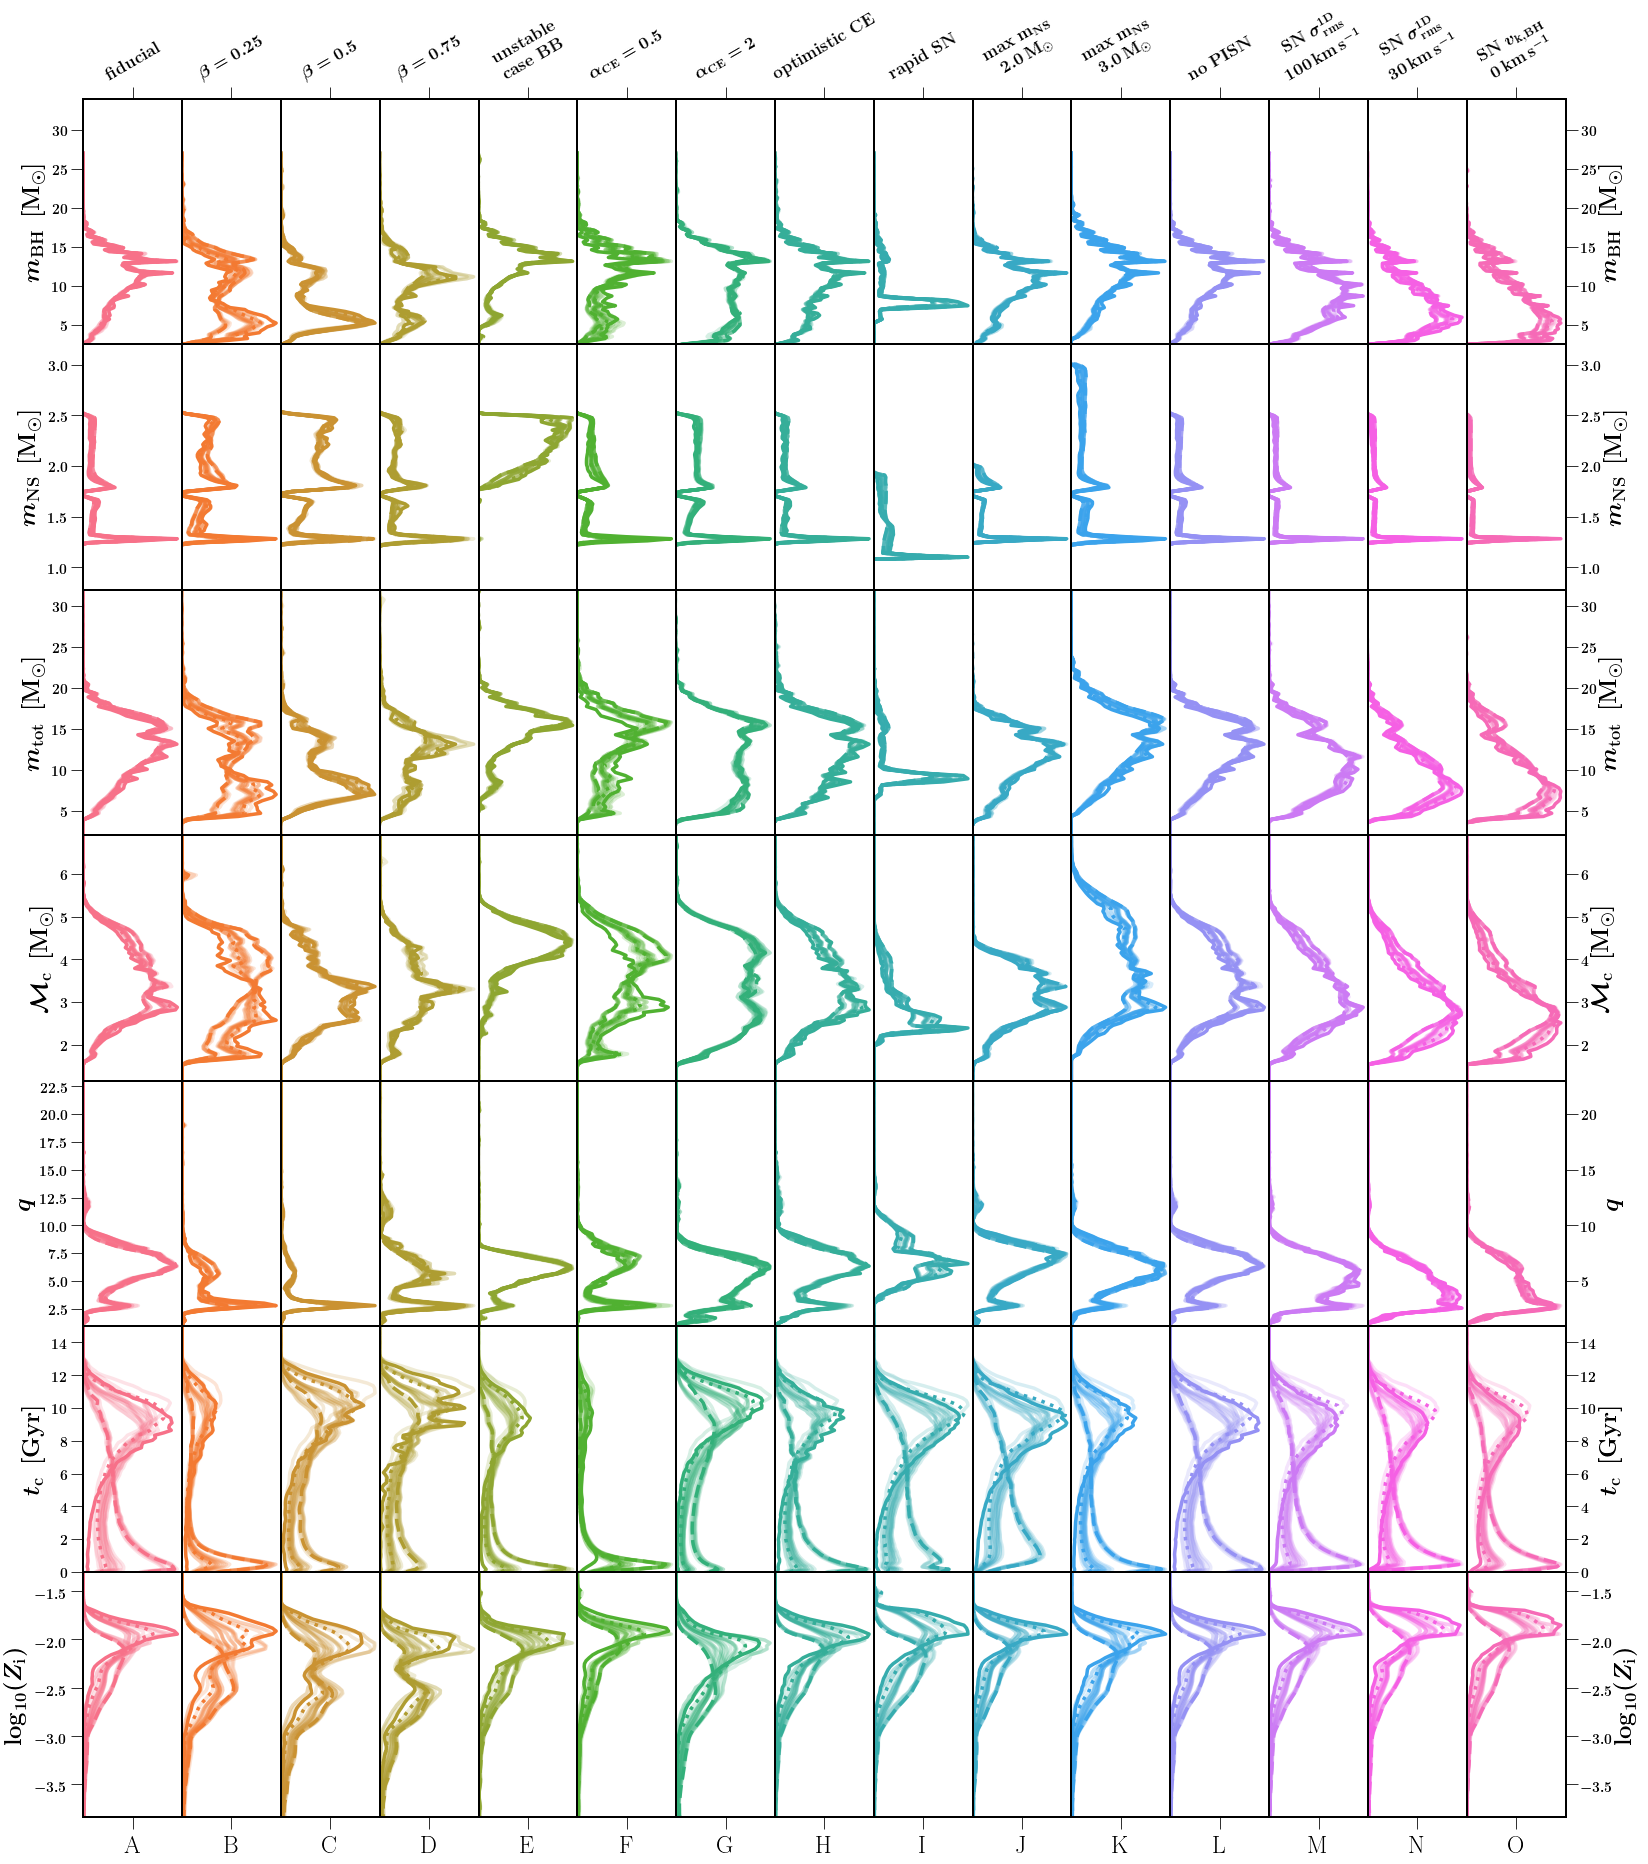

In [18]:

ncols, nrows= 15,7
f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(23,26), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})







for ind_bps, BPS in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']):
    Zsolar=0.0142
    nModels=15
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]
    MSSFRalphas = [1., 0.5, 0.5, 0.5]
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']

#     MSSFRnameslist = ['000', '231', '312']
    MSSFRnameslist = ['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
    # MSSFRnameslist = ['000', '111', '211']
    TYPE = 'BHNS'
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]
    BPScolors       = sns.color_palette("husl", len(BPSnameslist))
    colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}

#     f, ax= plt.subplots(ncols=3,nrows=2,figsize=(20,10))





    # Mass BH 

    xparamGroup='doubleCompactObjects'

    handles, labels = None, None
    BPSlist = [BPS]#,'B',  'C', 'D','F', 'G', 'K', 'L' ]
    whichBPScolor = [BPS]#, 'C', 'D', 'G', 'K', 'L' ]
    whichWeight='det'
    whichPlot = 'kde'

    nameX = r'  a'
    nameY = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'
    xparam='MBH'
    _,_=makeDistributionPlotManyModelsFlipped(axe=ax[0,ind_bps], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[2.5,27], xlabel=nameX, ylabel=nameY, \
                                  xlim=[2.5,34], ylim=[0.001,1.05], indplot=0, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 

    nameX = r'$-  $'
    nameY = r' $m_{\rm{NS}} $ $ \,  [\rm{M}_{\odot}]$'
    xparam='MNS'
    _,_=makeDistributionPlotManyModelsFlipped(axe=ax[1,ind_bps], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1,3], xlabel=nameX, ylabel=nameY, \
                                  xlim=[0.78,3.2], ylim=[0.1,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor)     
    
#     nameX = r'${\rm{d}}P / {\rm{d}}  m_{\rm{tot}}  $'
    nameY = r' $m_{\rm{tot}}$ $ \,  [\rm{M}_{\odot}]$'
    xparam='Mtot'
    _,_=makeDistributionPlotManyModelsFlipped(axe=ax[2,ind_bps], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[2,40], xlabel=nameX, ylabel=nameY, \
                                  xlim=[2,32], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 


#     nameX = r'${\rm{d}}P / {\rm{d}} {M}_{\rm{c}}  $'
    nameY = r' $\mathcal{M}_{\rm{c}}$ $ \,  [\rm{M}_{\odot}]$'
    xparam='Mchirp'
    _,_=makeDistributionPlotManyModelsFlipped(axe=ax[3,ind_bps], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1, 7], xlabel=nameX, ylabel=nameY, \
                                  xlim=[1.16,6.9], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 
    

#     nameX = r'${\rm{d}}P / {\rm{d}} q  $'
    nameY = r' $q$ $ \, $'
    xparam='q'
    _,_=makeDistributionPlotManyModelsFlipped(axe=ax[4,ind_bps], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1,23], xlabel=nameX, ylabel=nameY, \
                                  xlim=[0.92,23], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor)     



    nameY = r' $t_{\rm{c}}$ $ \, [{\rm{Gyr}}]$'
    xparam='tc'
    _,_=makeDistributionPlotManyModelsFlipped(axe=ax[5,ind_bps], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[0,15], xlabel=nameX, ylabel=nameY, \
                                  xlim=[0,14.99], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor)      

    
    nameX = r'  $- $ '
    nameY = r' $\log_{10}(Z_{\rm{i}})$ $ \, $'
    xparam='logZ'    
    
    xmin,xmax=[-2,0.55]
    xmin = np.log10((10**(-2))*Zsolar)
    xmax = np.log10((10**(0.55))*Zsolar)
    _,_=makeDistributionPlotManyModelsFlipped(axe=ax[6,ind_bps], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[xmin-0.5,xmax], xlabel=nameX, ylabel=nameY, \
                                  xlim=[xmin,xmax], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('./MakeFigure14_(SUPER_kdePlot)/' + whichWeight   +'SUPER_KDE.png', transparent=False)
plt.show()
plt.close()




# 943254
# 986353
#943254
# 986353







In [ ]:
A, B, C, D, E, F, G, H, I, J, K, L,  M,  N,  O --> mchirp

('now at m=', 'A')
MBH
('bw=', 0.00936084646459439)
('bandwith for model ', 'A', ' is bw= ', 0.04)
('now at m=', 'A')
MNS
('bw=', 0.00936084646459439)
('bandwith for model ', 'A', ' is bw= ', 0.04)
('now at m=', 'A')
q
('bw=', 0.00936084646459439)
('bandwith for model ', 'A', ' is bw= ', 0.04)
('now at m=', 'A')
logZ
logZ !!
('bw=', 0.00936084646459439)
('bandwith for model ', 'A', ' is bw= ', 0.1)
('now at m=', 'A')
Mtot
('bw=', 0.00936084646459439)
('bandwith for model ', 'A', ' is bw= ', 0.04)
('now at m=', 'A')
Mchirp
('bw=', 0.00936084646459439)
('bandwith for model ', 'A', ' is bw= ', 0.04)


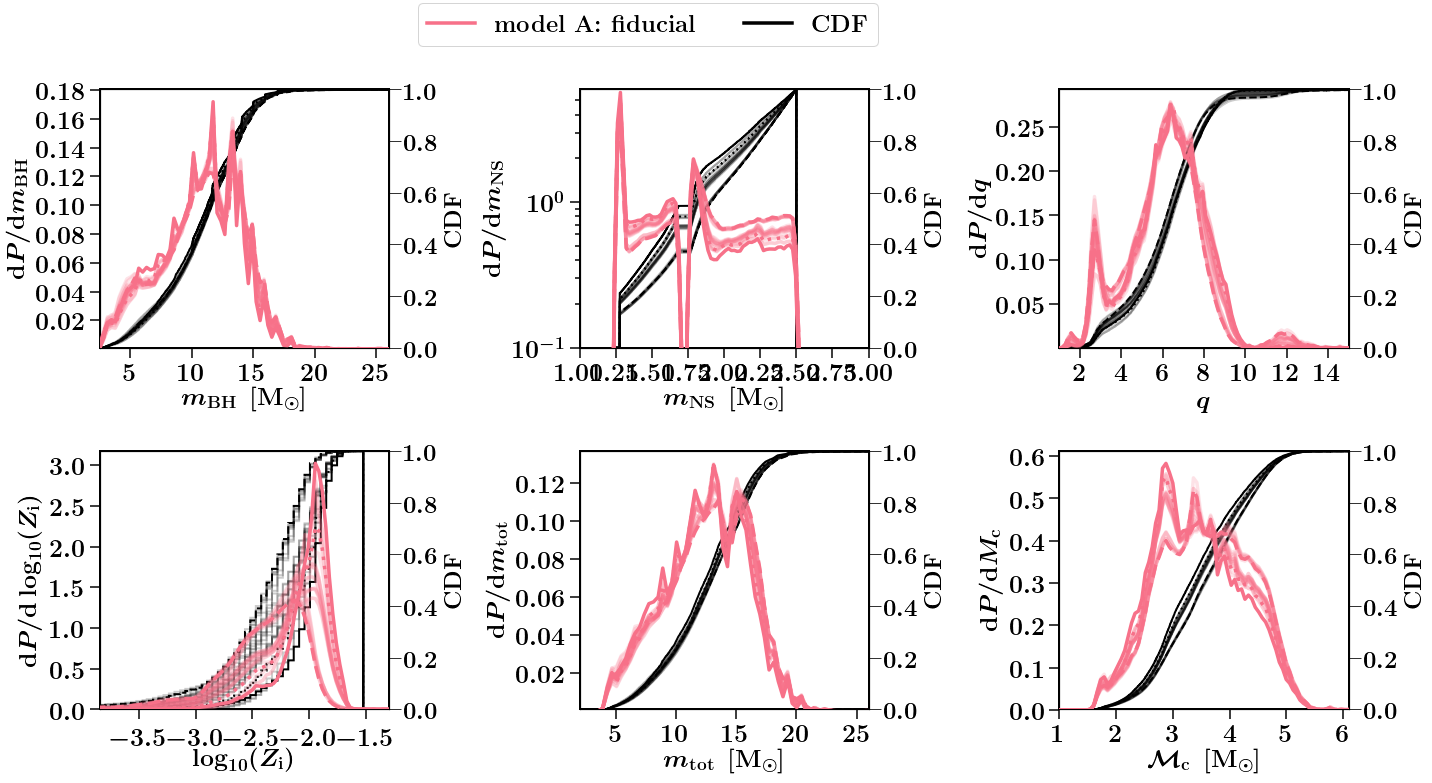

('now at m=', 'B')
MBH
('bw=', 0.014465989564479717)
('bandwith for model ', 'B', ' is bw= ', 0.05)
('now at m=', 'B')
MNS
('bw=', 0.014465989564479717)
('bandwith for model ', 'B', ' is bw= ', 0.05)
('now at m=', 'B')
q
('bw=', 0.014465989564479717)
('bandwith for model ', 'B', ' is bw= ', 0.05)
('now at m=', 'B')
logZ
logZ !!
('bw=', 0.014465989564479717)
('bandwith for model ', 'B', ' is bw= ', 0.1)
('now at m=', 'B')
Mtot
('bw=', 0.014465989564479717)
('bandwith for model ', 'B', ' is bw= ', 0.05)
('now at m=', 'B')
Mchirp
('bw=', 0.014465989564479717)
('bandwith for model ', 'B', ' is bw= ', 0.05)


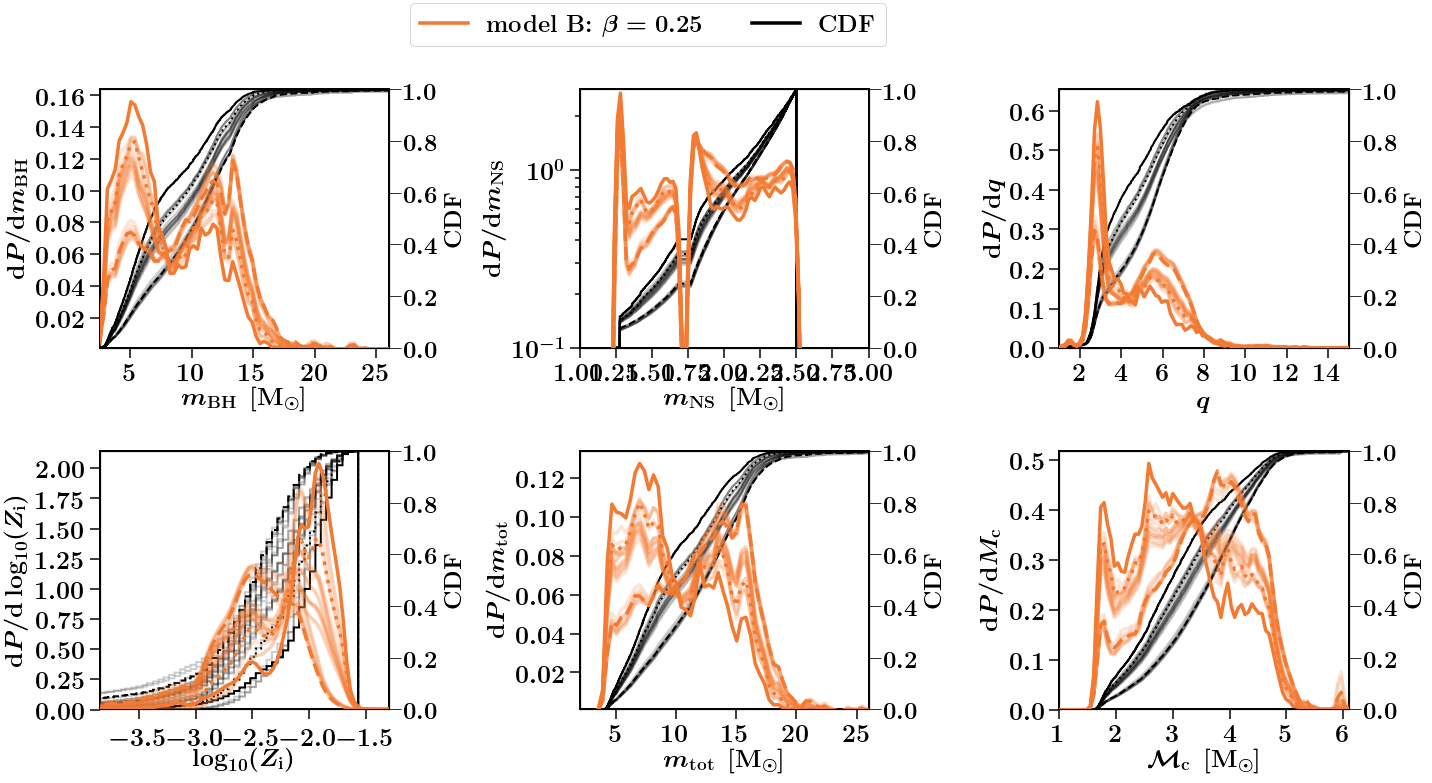

('now at m=', 'C')
MBH
('bw=', 0.03794362119060717)
('bandwith for model ', 'C', ' is bw= ', 0.06)
('now at m=', 'C')
MNS
('bw=', 0.03794362119060717)
('bandwith for model ', 'C', ' is bw= ', 0.06)
('now at m=', 'C')
q
('bw=', 0.03794362119060717)
('bandwith for model ', 'C', ' is bw= ', 0.06)
('now at m=', 'C')
logZ
logZ !!
('bw=', 0.03794362119060717)
('bandwith for model ', 'C', ' is bw= ', 0.1)
('now at m=', 'C')
Mtot
('bw=', 0.03794362119060717)
('bandwith for model ', 'C', ' is bw= ', 0.06)
('now at m=', 'C')
Mchirp
('bw=', 0.03794362119060717)
('bandwith for model ', 'C', ' is bw= ', 0.06)


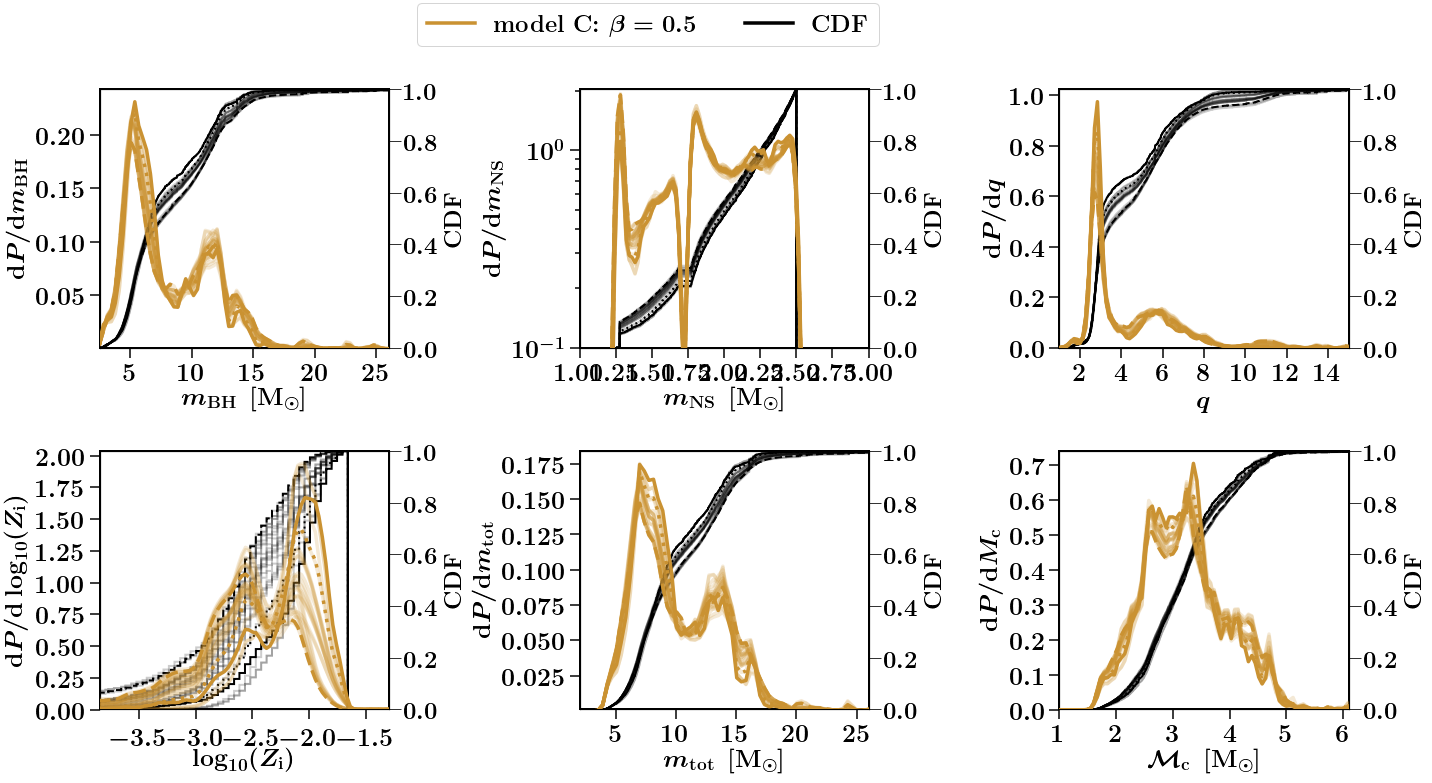

('now at m=', 'D')
MBH
('bw=', 0.043272936830502345)
('bandwith for model ', 'D', ' is bw= ', 0.06)
('now at m=', 'D')
MNS
('bw=', 0.043272936830502345)
('bandwith for model ', 'D', ' is bw= ', 0.06)
('now at m=', 'D')
q
('bw=', 0.043272936830502345)
('bandwith for model ', 'D', ' is bw= ', 0.06)
('now at m=', 'D')
logZ
logZ !!
('bw=', 0.043272936830502345)
('bandwith for model ', 'D', ' is bw= ', 0.1)
('now at m=', 'D')
Mtot
('bw=', 0.043272936830502345)
('bandwith for model ', 'D', ' is bw= ', 0.06)
('now at m=', 'D')
Mchirp
('bw=', 0.043272936830502345)
('bandwith for model ', 'D', ' is bw= ', 0.06)


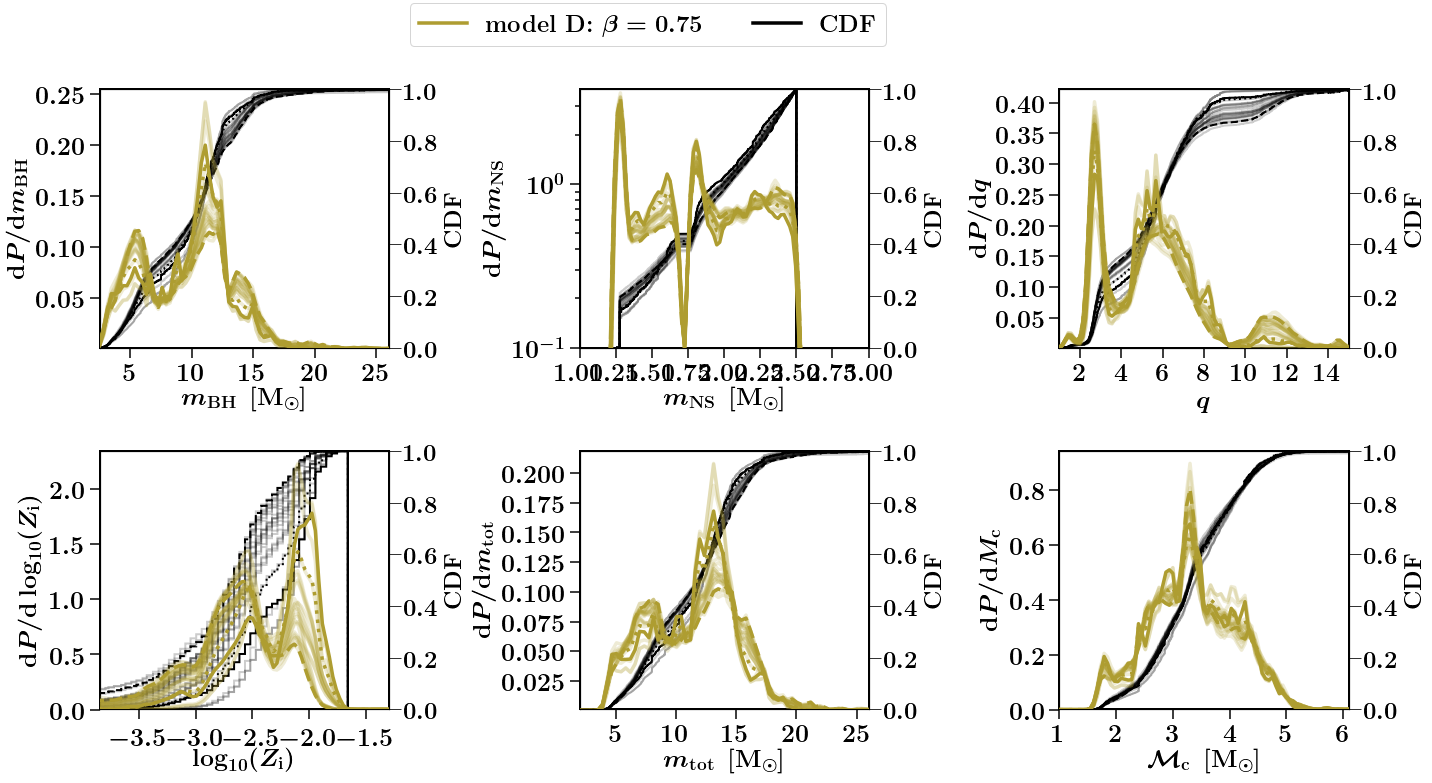

('now at m=', 'E')
MBH
('bw=', 0.019251873765552253)
('bandwith for model ', 'E', ' is bw= ', 0.06)
('now at m=', 'E')
MNS
('bw=', 0.019251873765552253)
('bandwith for model ', 'E', ' is bw= ', 0.06)
('now at m=', 'E')
q
('bw=', 0.019251873765552253)
('bandwith for model ', 'E', ' is bw= ', 0.06)
('now at m=', 'E')
logZ
logZ !!
('bw=', 0.019251873765552253)
('bandwith for model ', 'E', ' is bw= ', 0.1)
('now at m=', 'E')
Mtot
('bw=', 0.019251873765552253)
('bandwith for model ', 'E', ' is bw= ', 0.06)
('now at m=', 'E')
Mchirp
('bw=', 0.019251873765552253)
('bandwith for model ', 'E', ' is bw= ', 0.06)


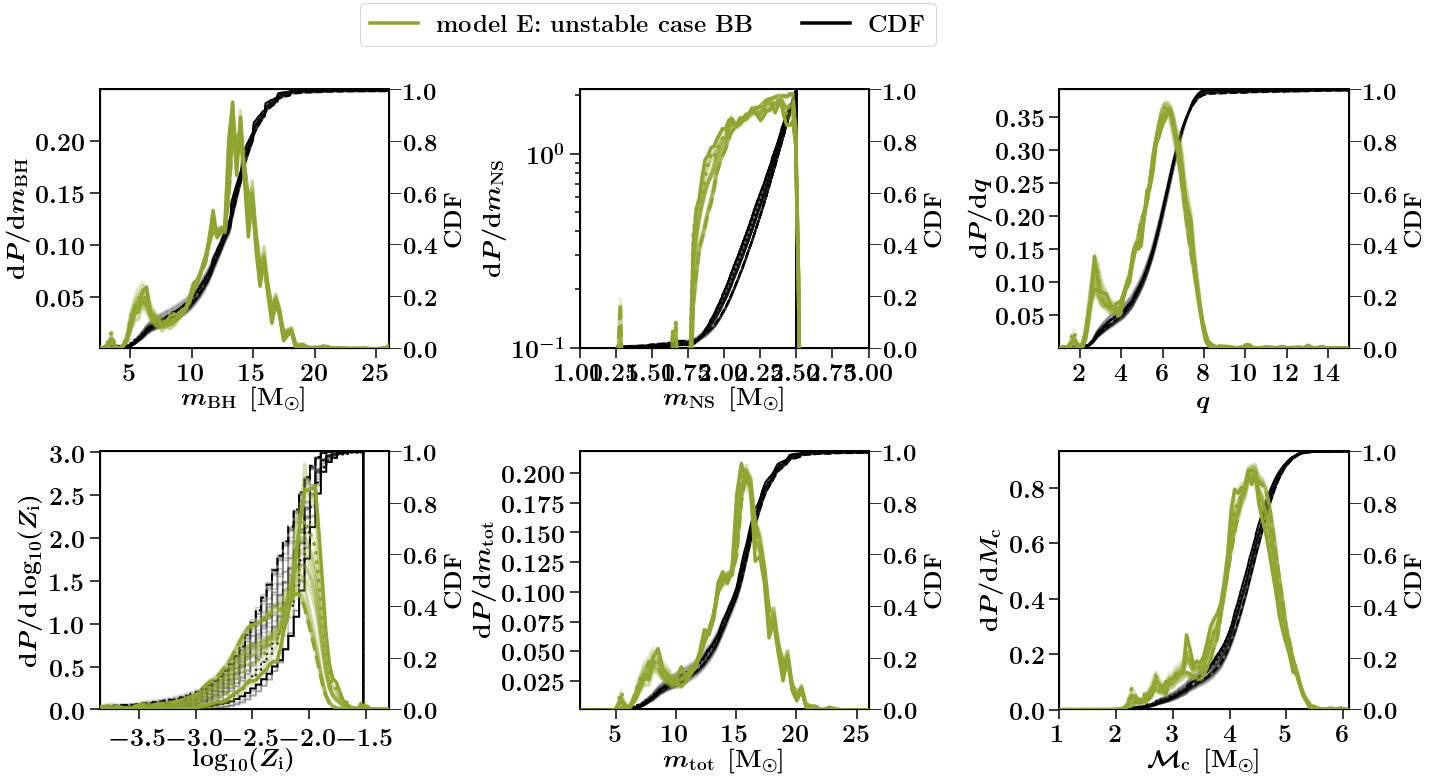

('now at m=', 'F')
MBH
('bw=', 0.012719436589765508)
('bandwith for model ', 'F', ' is bw= ', 0.04)
('now at m=', 'F')
MNS
('bw=', 0.012719436589765508)
('bandwith for model ', 'F', ' is bw= ', 0.04)
('now at m=', 'F')
q
('bw=', 0.012719436589765508)
('bandwith for model ', 'F', ' is bw= ', 0.04)
('now at m=', 'F')
logZ
logZ !!
('bw=', 0.012719436589765508)
('bandwith for model ', 'F', ' is bw= ', 0.1)
('now at m=', 'F')
Mtot
('bw=', 0.012719436589765508)
('bandwith for model ', 'F', ' is bw= ', 0.04)
('now at m=', 'F')
Mchirp
('bw=', 0.012719436589765508)
('bandwith for model ', 'F', ' is bw= ', 0.04)


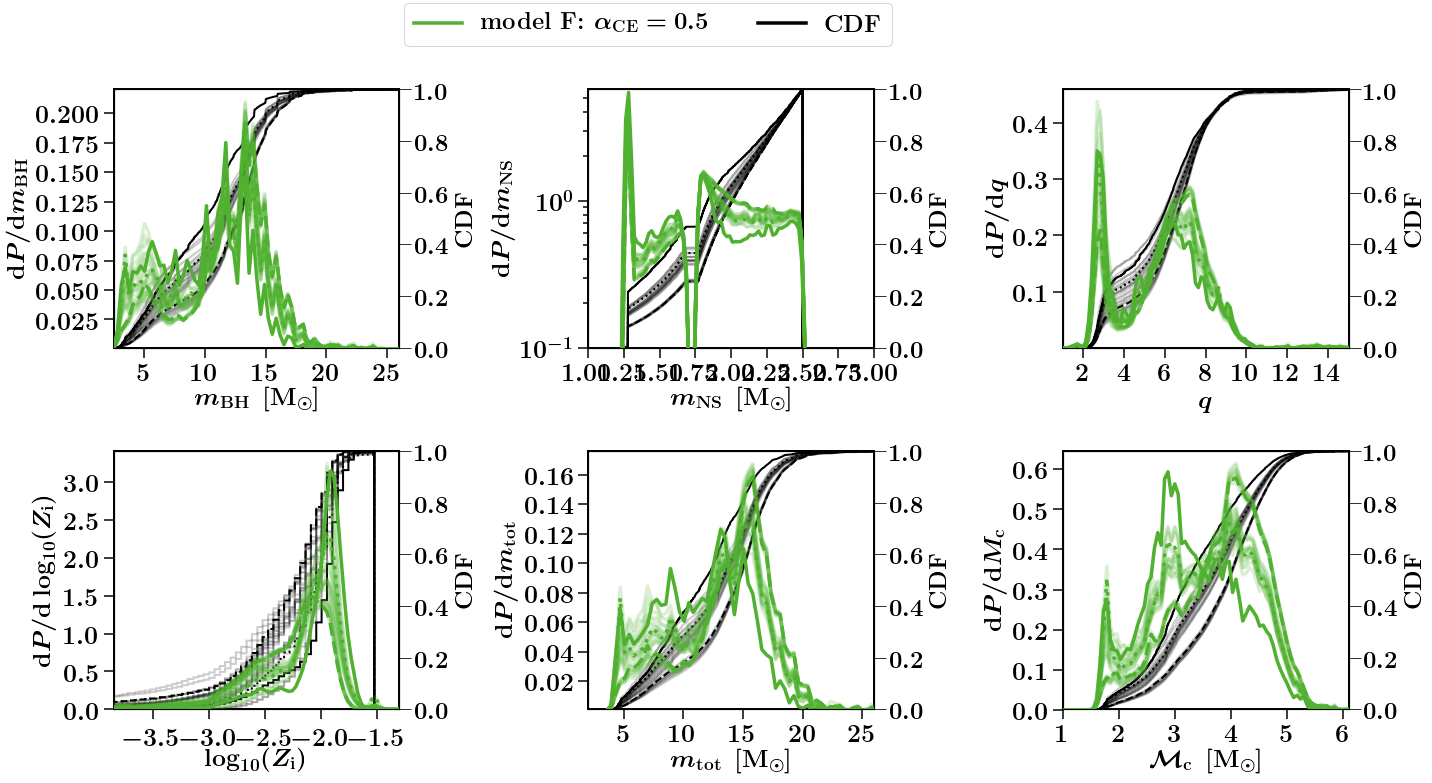

('now at m=', 'G')
MBH
('bw=', 0.013453927614755229)
('bandwith for model ', 'G', ' is bw= ', 0.05)
('now at m=', 'G')
MNS
('bw=', 0.013453927614755229)
('bandwith for model ', 'G', ' is bw= ', 0.05)
('now at m=', 'G')
q
('bw=', 0.013453927614755229)
('bandwith for model ', 'G', ' is bw= ', 0.05)
('now at m=', 'G')
logZ
logZ !!
('bw=', 0.013453927614755229)
('bandwith for model ', 'G', ' is bw= ', 0.1)
('now at m=', 'G')
Mtot
('bw=', 0.013453927614755229)
('bandwith for model ', 'G', ' is bw= ', 0.05)
('now at m=', 'G')
Mchirp
('bw=', 0.013453927614755229)
('bandwith for model ', 'G', ' is bw= ', 0.05)


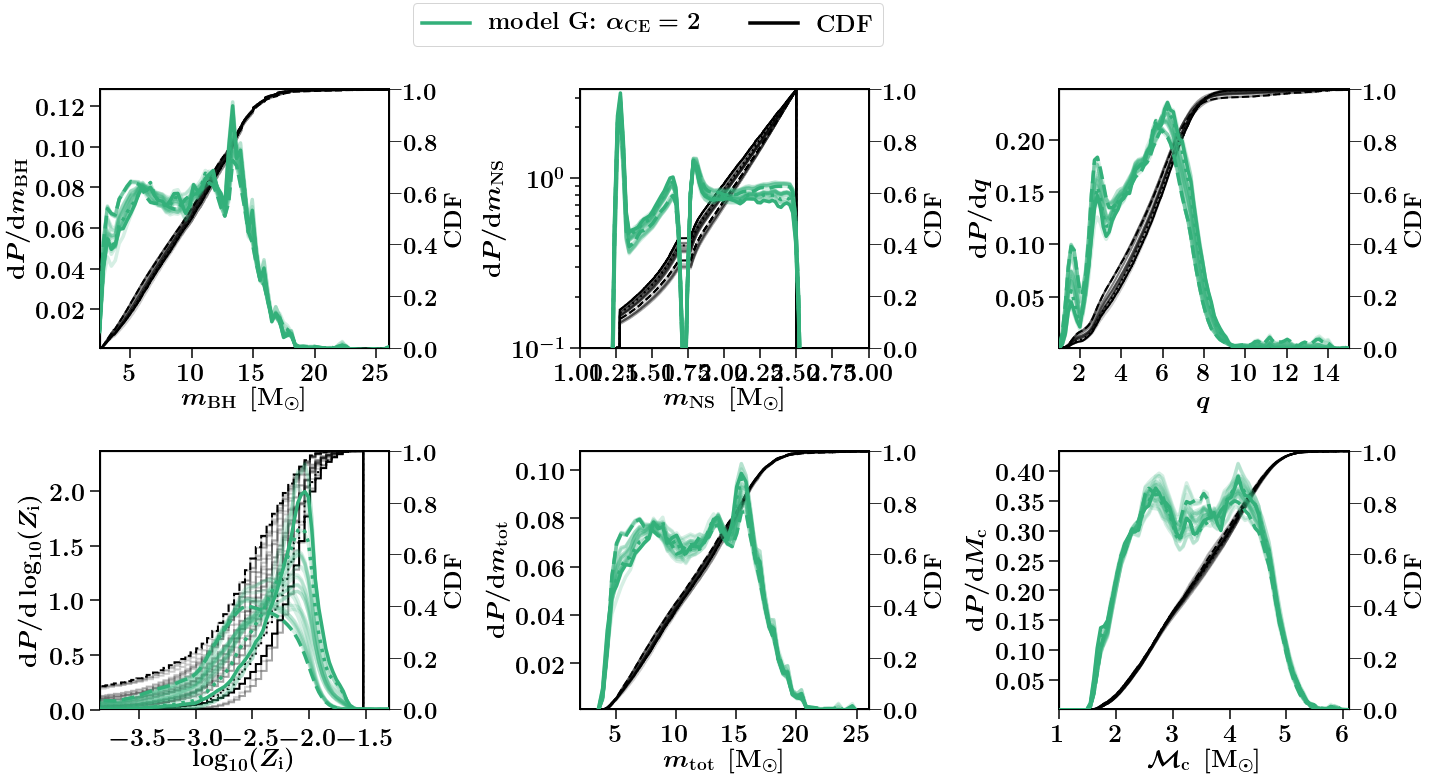

('now at m=', 'H')
MBH
('bw=', 0.009326084468724962)
('bandwith for model ', 'H', ' is bw= ', 0.04)
('now at m=', 'H')
MNS
('bw=', 0.009326084468724962)
('bandwith for model ', 'H', ' is bw= ', 0.04)
('now at m=', 'H')
q
('bw=', 0.009326084468724962)
('bandwith for model ', 'H', ' is bw= ', 0.04)
('now at m=', 'H')
logZ
logZ !!
('bw=', 0.009326084468724962)
('bandwith for model ', 'H', ' is bw= ', 0.1)
('now at m=', 'H')
Mtot
('bw=', 0.009326084468724962)
('bandwith for model ', 'H', ' is bw= ', 0.04)
('now at m=', 'H')
Mchirp
('bw=', 0.009326084468724962)
('bandwith for model ', 'H', ' is bw= ', 0.04)


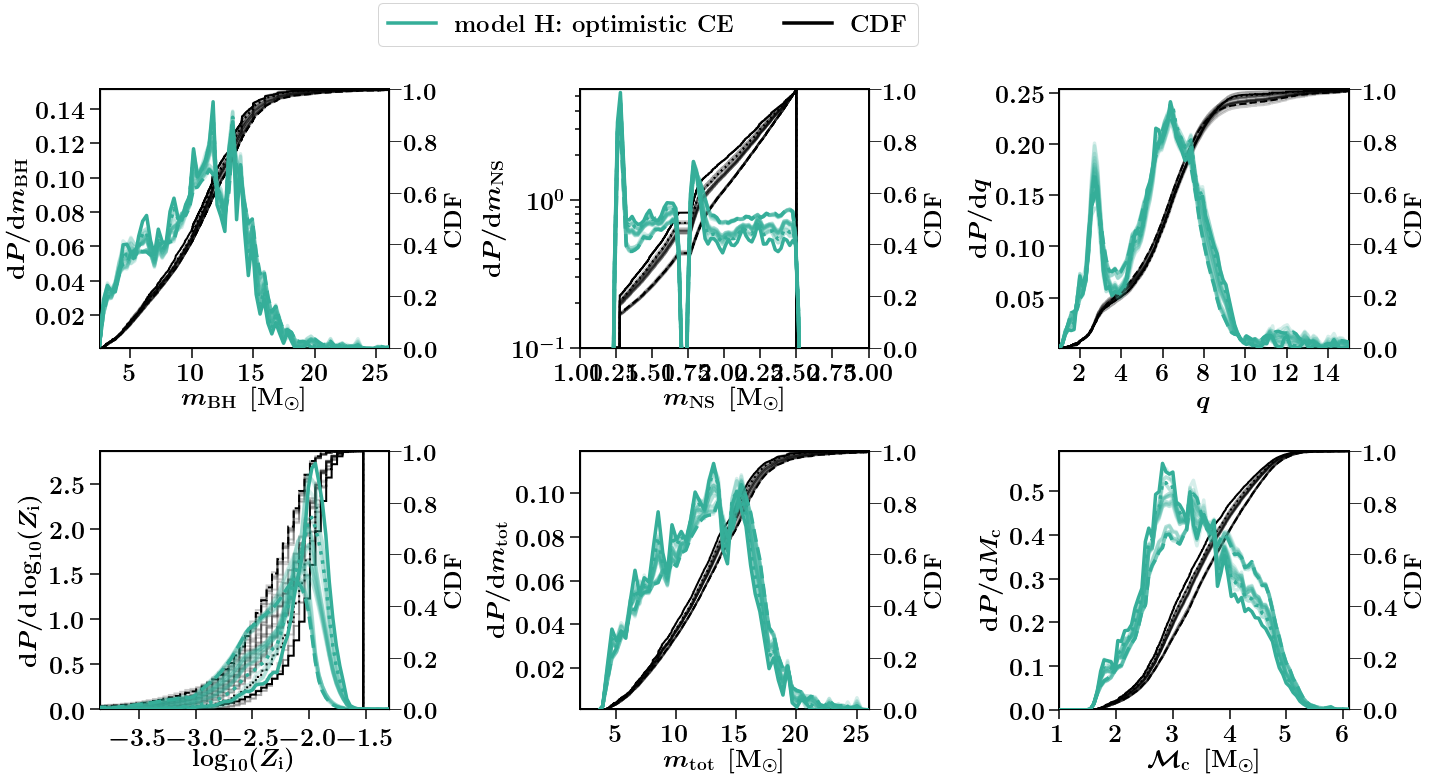

('now at m=', 'I')
MBH
('bw=', 0.006549861618471605)
('bandwith for model ', 'I', ' is bw= ', 0.03)
('now at m=', 'I')
MNS
('bw=', 0.006549861618471605)
('bandwith for model ', 'I', ' is bw= ', 0.03)
('now at m=', 'I')
q
('bw=', 0.006549861618471605)
('bandwith for model ', 'I', ' is bw= ', 0.03)
('now at m=', 'I')
logZ
logZ !!
('bw=', 0.006549861618471605)
('bandwith for model ', 'I', ' is bw= ', 0.1)
('now at m=', 'I')
Mtot
('bw=', 0.006549861618471605)
('bandwith for model ', 'I', ' is bw= ', 0.03)
('now at m=', 'I')
Mchirp
('bw=', 0.006549861618471605)
('bandwith for model ', 'I', ' is bw= ', 0.03)


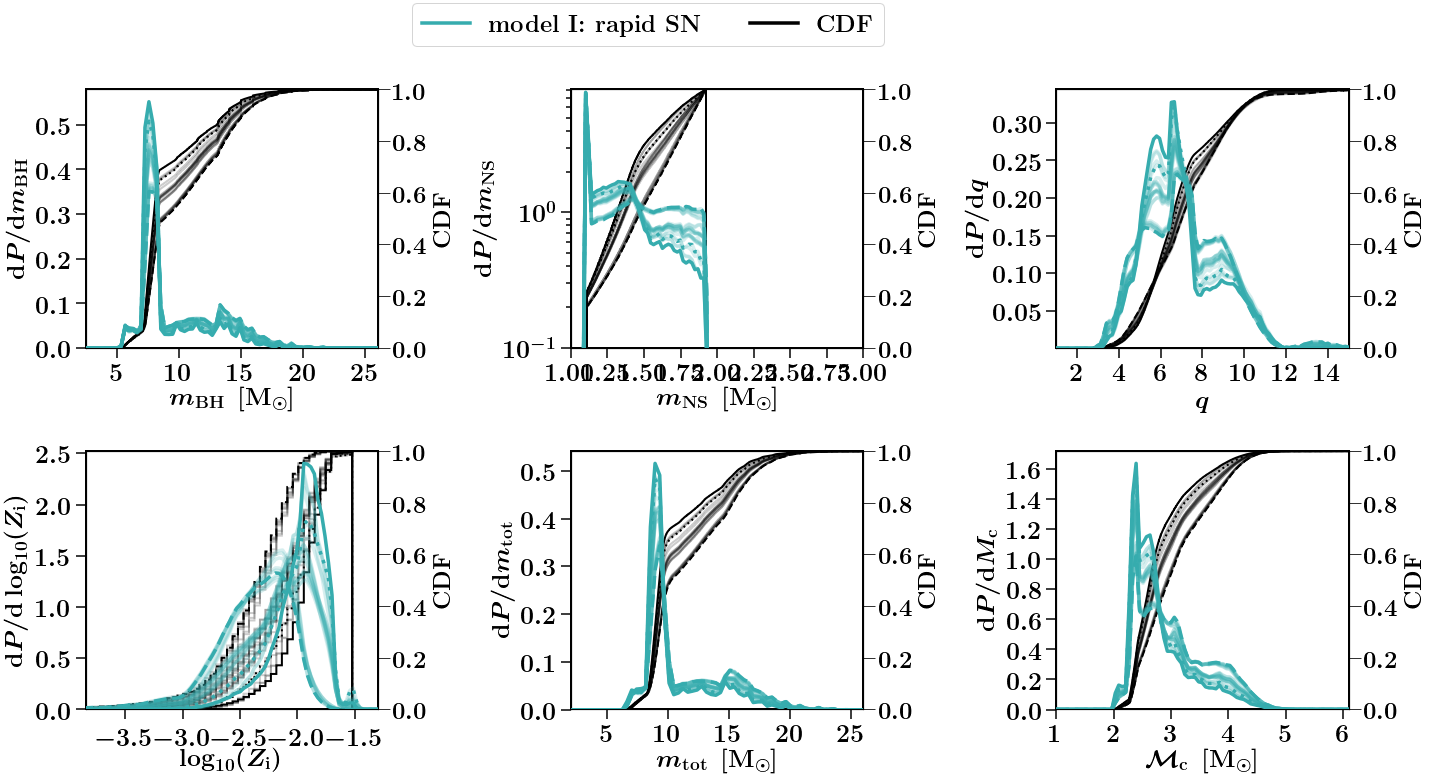

('now at m=', 'J')
MBH
('bw=', 0.012361299836680401)
('bandwith for model ', 'J', ' is bw= ', 0.04)
('now at m=', 'J')
MNS
('bw=', 0.012361299836680401)
('bandwith for model ', 'J', ' is bw= ', 0.04)
('now at m=', 'J')
q
('bw=', 0.012361299836680401)
('bandwith for model ', 'J', ' is bw= ', 0.04)
('now at m=', 'J')
logZ
logZ !!
('bw=', 0.012361299836680401)
('bandwith for model ', 'J', ' is bw= ', 0.1)
('now at m=', 'J')
Mtot
('bw=', 0.012361299836680401)
('bandwith for model ', 'J', ' is bw= ', 0.04)
('now at m=', 'J')
Mchirp
('bw=', 0.012361299836680401)
('bandwith for model ', 'J', ' is bw= ', 0.04)


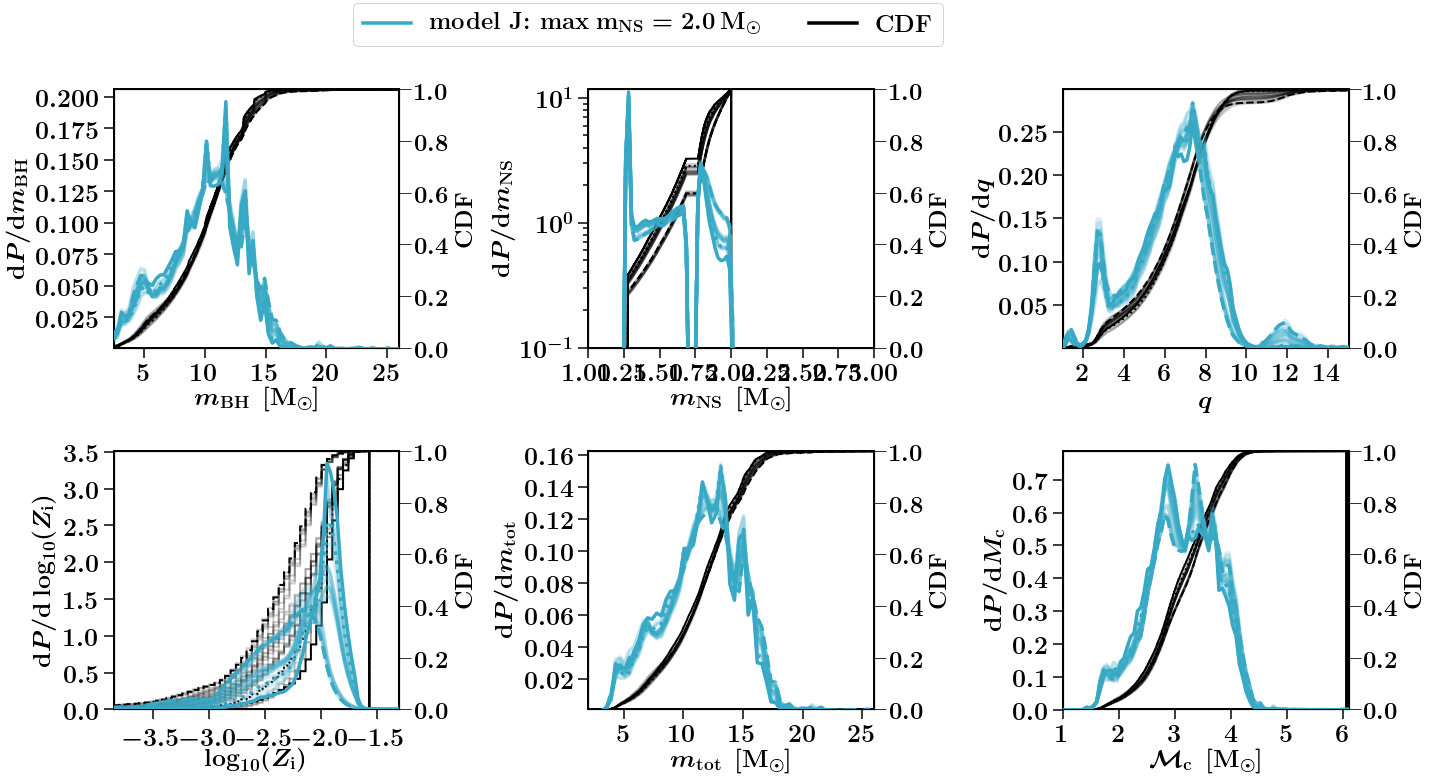

('now at m=', 'K')
MBH
('bw=', 0.007980249116162953)
('bandwith for model ', 'K', ' is bw= ', 0.03)
('now at m=', 'K')
MNS
('bw=', 0.007980249116162953)
('bandwith for model ', 'K', ' is bw= ', 0.03)
('now at m=', 'K')
q
('bw=', 0.007980249116162953)
('bandwith for model ', 'K', ' is bw= ', 0.03)
('now at m=', 'K')
logZ
logZ !!
('bw=', 0.007980249116162953)
('bandwith for model ', 'K', ' is bw= ', 0.1)
('now at m=', 'K')
Mtot
('bw=', 0.007980249116162953)
('bandwith for model ', 'K', ' is bw= ', 0.03)
('now at m=', 'K')
Mchirp
('bw=', 0.007980249116162953)
('bandwith for model ', 'K', ' is bw= ', 0.03)


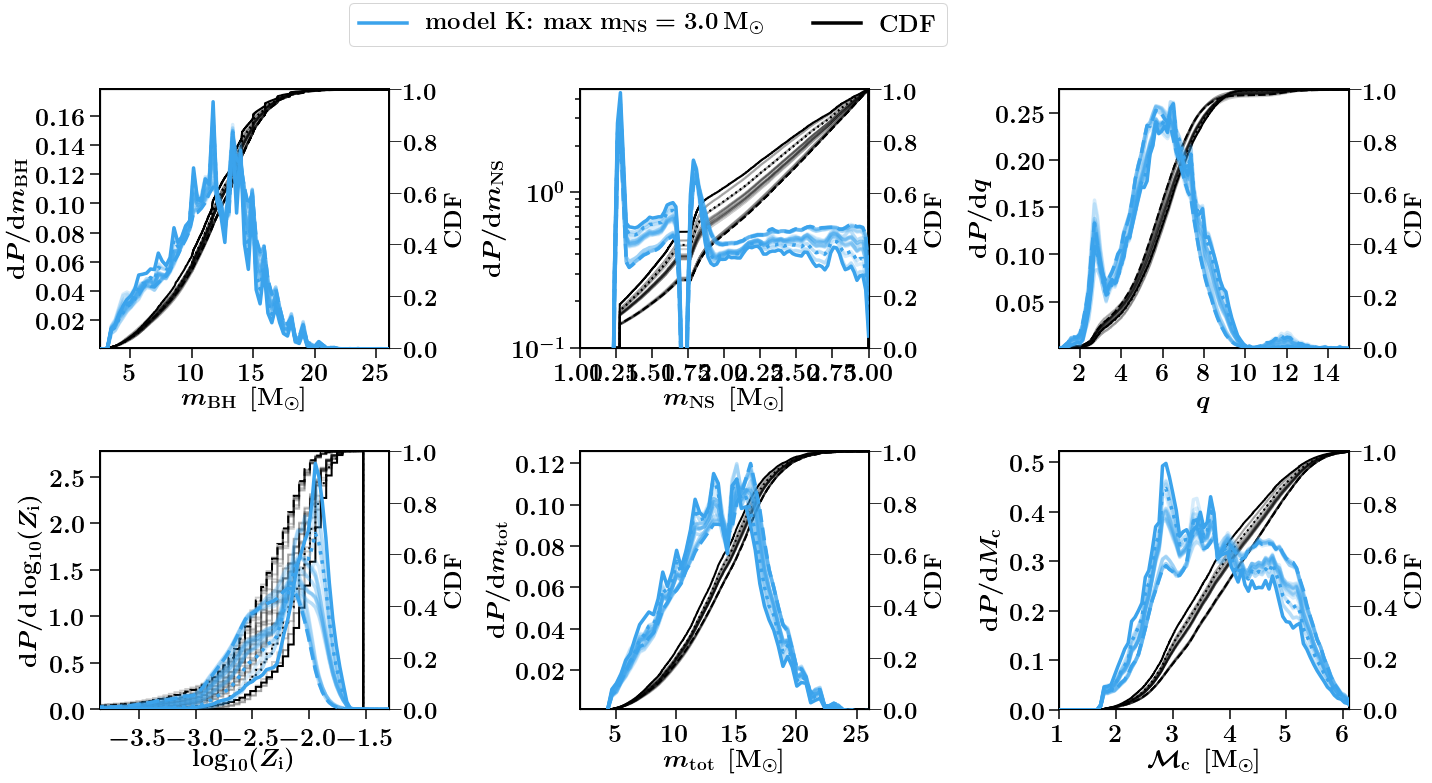

('now at m=', 'L')
MBH
('bw=', 0.009364736410533994)
('bandwith for model ', 'L', ' is bw= ', 0.04)
('now at m=', 'L')
MNS
('bw=', 0.009364736410533994)
('bandwith for model ', 'L', ' is bw= ', 0.04)
('now at m=', 'L')
q
('bw=', 0.009364736410533994)
('bandwith for model ', 'L', ' is bw= ', 0.04)
('now at m=', 'L')
logZ
logZ !!
('bw=', 0.009364736410533994)
('bandwith for model ', 'L', ' is bw= ', 0.1)
('now at m=', 'L')
Mtot
('bw=', 0.009364736410533994)
('bandwith for model ', 'L', ' is bw= ', 0.04)
('now at m=', 'L')
Mchirp
('bw=', 0.009364736410533994)
('bandwith for model ', 'L', ' is bw= ', 0.04)


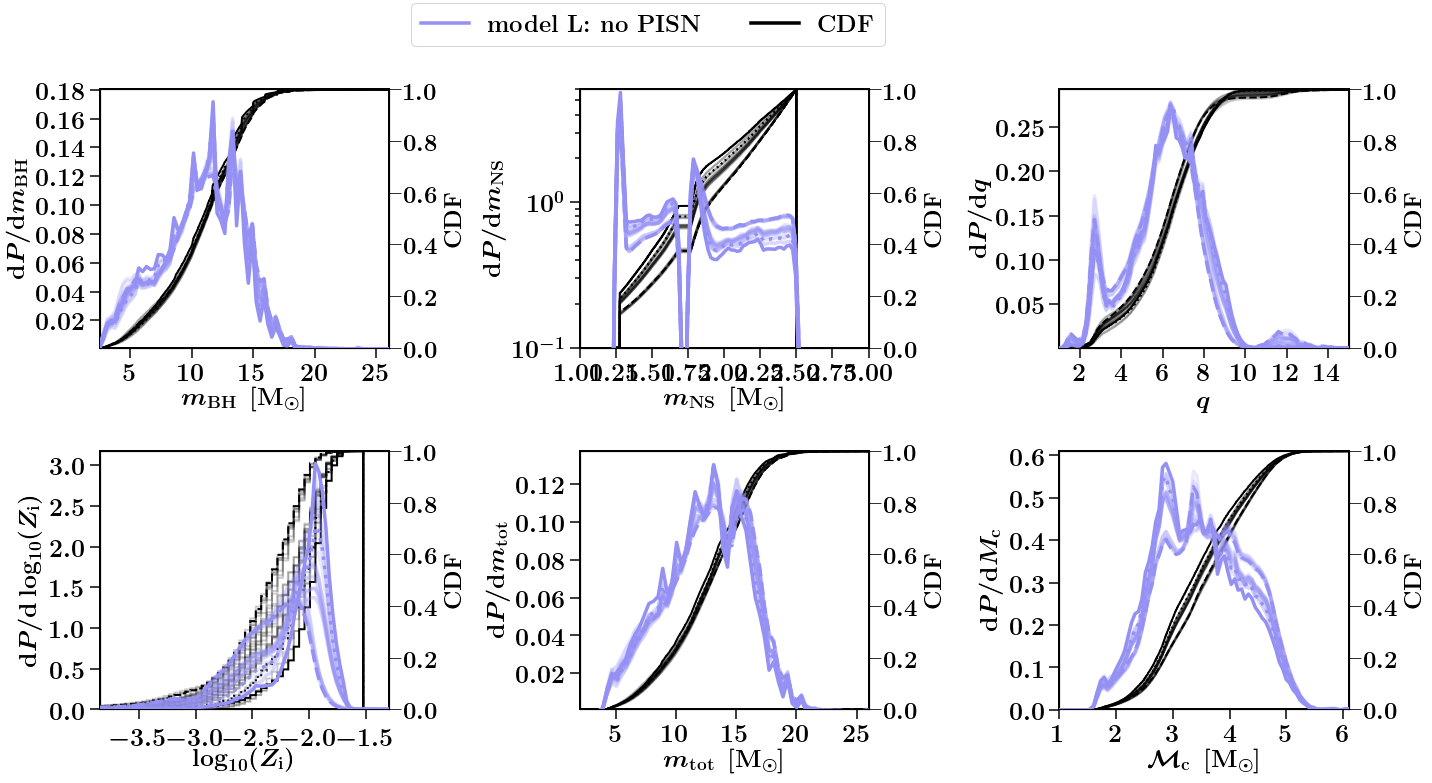

('now at m=', 'M')
MBH
('bw=', 0.006177857812351784)
('bandwith for model ', 'M', ' is bw= ', 0.03)
('now at m=', 'M')
MNS
('bw=', 0.006177857812351784)
('bandwith for model ', 'M', ' is bw= ', 0.03)
('now at m=', 'M')
q
('bw=', 0.006177857812351784)
('bandwith for model ', 'M', ' is bw= ', 0.03)
('now at m=', 'M')
logZ
logZ !!
('bw=', 0.006177857812351784)
('bandwith for model ', 'M', ' is bw= ', 0.1)
('now at m=', 'M')
Mtot
('bw=', 0.006177857812351784)
('bandwith for model ', 'M', ' is bw= ', 0.03)
('now at m=', 'M')
Mchirp
('bw=', 0.006177857812351784)
('bandwith for model ', 'M', ' is bw= ', 0.03)


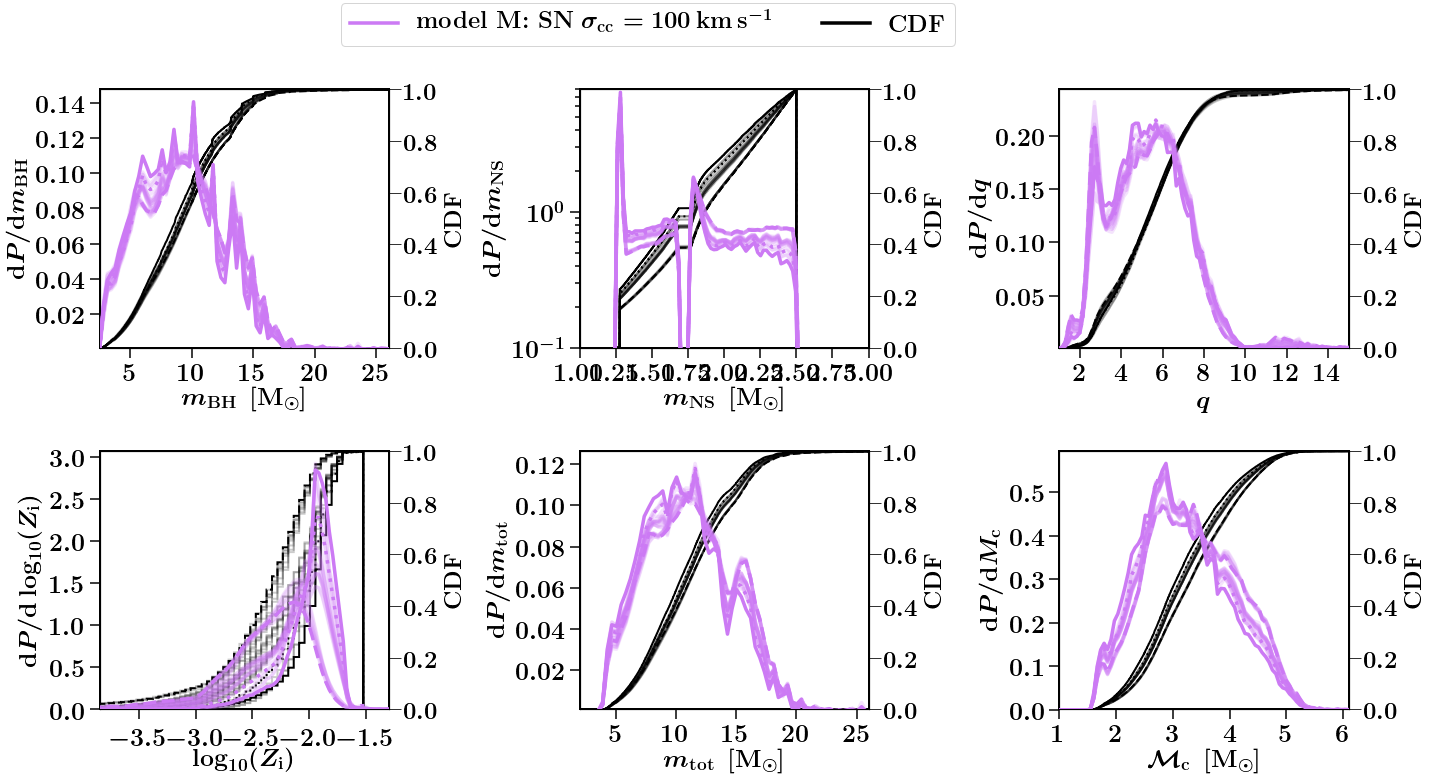

('now at m=', 'N')
MBH
('bw=', 0.005099543127865829)
('bandwith for model ', 'N', ' is bw= ', 0.03)
('now at m=', 'N')
MNS
('bw=', 0.005099543127865829)
('bandwith for model ', 'N', ' is bw= ', 0.03)
('now at m=', 'N')
q
('bw=', 0.005099543127865829)
('bandwith for model ', 'N', ' is bw= ', 0.03)
('now at m=', 'N')
logZ
logZ !!
('bw=', 0.005099543127865829)
('bandwith for model ', 'N', ' is bw= ', 0.1)
('now at m=', 'N')
Mtot
('bw=', 0.005099543127865829)
('bandwith for model ', 'N', ' is bw= ', 0.03)
('now at m=', 'N')
Mchirp
('bw=', 0.005099543127865829)
('bandwith for model ', 'N', ' is bw= ', 0.03)


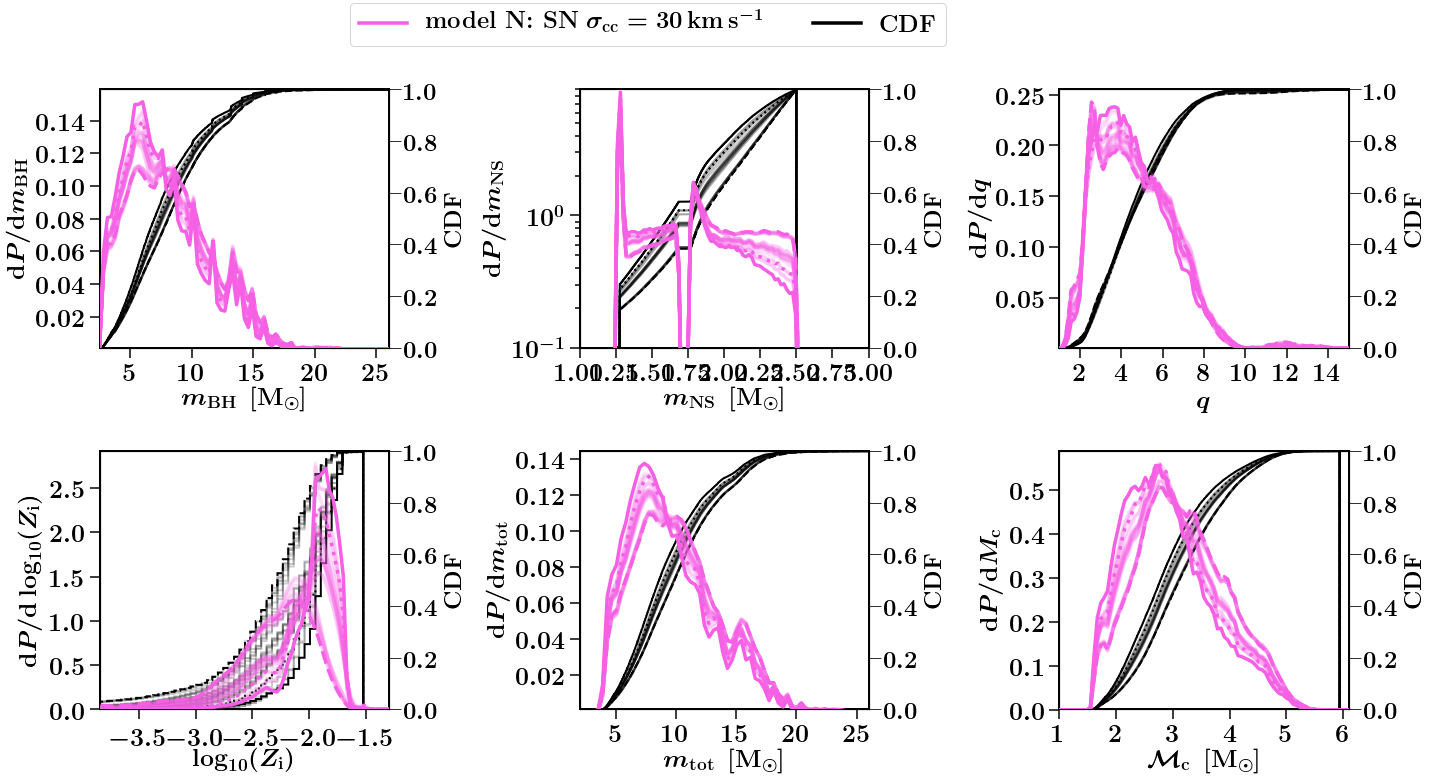

('now at m=', 'O')
MBH
('bw=', 0.004554463764959286)
('bandwith for model ', 'O', ' is bw= ', 0.03)
('now at m=', 'O')
MNS
('bw=', 0.004554463764959286)
('bandwith for model ', 'O', ' is bw= ', 0.03)
('now at m=', 'O')
q
('bw=', 0.004554463764959286)
('bandwith for model ', 'O', ' is bw= ', 0.03)
('now at m=', 'O')
logZ
logZ !!
('bw=', 0.004554463764959286)
('bandwith for model ', 'O', ' is bw= ', 0.1)
('now at m=', 'O')
Mtot
('bw=', 0.004554463764959286)
('bandwith for model ', 'O', ' is bw= ', 0.03)
('now at m=', 'O')
Mchirp
('bw=', 0.004554463764959286)
('bandwith for model ', 'O', ' is bw= ', 0.03)


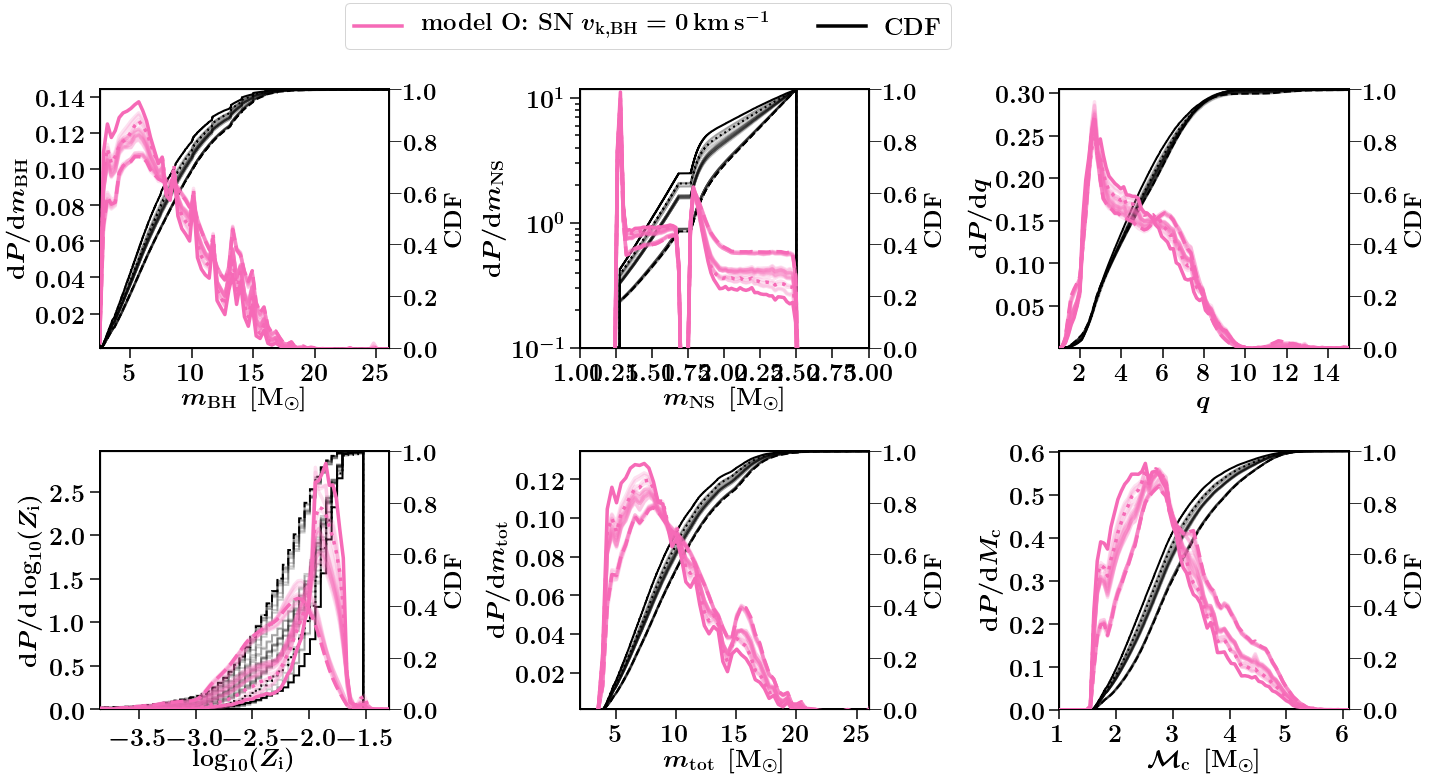

In [8]:

for BPS in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']:
    Zsolar=0.0142
    nModels=15
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]
    MSSFRalphas = [1., 0.5, 0.5, 0.5]
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']

#     MSSFRnameslist = ['000', '231', '312']
    MSSFRnameslist = ['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
    # MSSFRnameslist = ['000', '111', '211']
    TYPE = 'BHNS'
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]
    BPScolors       = sns.color_palette("husl", len(BPSnameslist))
    colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}

    f, ax= plt.subplots(ncols=3,nrows=2,figsize=(20,10))





    # Mass BH 

    xparamGroup='doubleCompactObjects'

    handles, labels = None, None
    BPSlist = [BPS]#,'B',  'C', 'D','F', 'G', 'K', 'L' ]
    whichBPScolor = [BPS]#, 'C', 'D', 'G', 'K', 'L' ]
    whichWeight='det'
    whichPlot = 'kde'

    nameY = r'${\rm{d}}P / {\rm{d}} m_{\rm{BH}}  $'
    nameX = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'
    xparam='MBH'
    _,_=makeDistributionPlotManyModels(axe=ax[0,0], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[2.5,34], xlabel=nameX, ylabel=nameY, \
                                  xlim=[2.5,26], ylim=[0.001,1.05], indplot=0, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 

    nameY = r'${\rm{d}}P / {\rm{d}} m_{\rm{NS}}  $'
    nameX = r' $m_{\rm{NS}} $ $ \,  [\rm{M}_{\odot}]$'
    xparam='MNS'
    _,_=makeDistributionPlotManyModels(axe=ax[0,1], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1,3], xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,3], ylim=[0.1,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 


    nameY = r'${\rm{d}}P / {\rm{d}} q  $'
    nameX = r' $q$ $ \, $'
    xparam='q'
    _,_=makeDistributionPlotManyModels(axe=ax[0,2], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1,15], xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,15], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 



    # nameY = r'${\rm{d}}P / {\rm{d}} \log_{10}(Z_{\rm{i}}/Z_{\odot})  $'
    # nameX = r' $\log_{10}(Z_{\rm{i}}/Z_{\odot})$ $ \, $'
    nameY = r'${\rm{d}}P / {\rm{d}} \log_{10}(Z_{\rm{i}})  $'
    nameX = r' $\log_{10}(Z_{\rm{i}})$ $ \, $'
    xparam='logZ'

    xmin,xmax=[-2,0.55]
    xmin = np.log10((10**(-2))*Zsolar)
    xmax = np.log10((10**(0.55))*Zsolar)
    _,_=makeDistributionPlotManyModels(axe=ax[1,0], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[xmin-0.5,xmax], xlabel=nameX, ylabel=nameY, \
                                  xlim=[xmin,xmax], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 


    nameY = r'${\rm{d}}P / {\rm{d}}  m_{\rm{tot}}  $'
    nameX = r' $m_{\rm{tot}}$ $ \,  [\rm{M}_{\odot}]$'
    xparam='Mtot'
    _,_=makeDistributionPlotManyModels(axe=ax[1,1], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[2,40], xlabel=nameX, ylabel=nameY, \
                                  xlim=[2,26], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 


    nameY = r'${\rm{d}}P / {\rm{d}} {M}_{\rm{c}}  $'
    nameX = r' $\mathcal{M}_{\rm{c}}$ $ \,  [\rm{M}_{\odot}]$'
    xparam='Mchirp'
    _,_=makeDistributionPlotManyModels(axe=ax[1,2], xparamGroup=xparamGroup,xparam=xparam,  BPSmodelNames=BPSlist,\
            MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1, 7], xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,6.1], ylim=[0.001,1.05], indplot=1, whichWeight=whichWeight, whichPlot=whichPlot, whichBPScolor=whichBPScolor) 


    labell = r'\textbf{model %s: }'%(BPSlist[0]) +  alphabetPhysicalNameDict[BPSlist[0]]
    x_=[-11,-11]
    ax[1,2].plot(x_, x_, lw=3.5, color=colorDirDict[BPSlist[0]], label=labell)
    ax[1,2].plot(x_, x_, lw=3.5, color='k', label=r'\textbf{CDF}')



    ## OLD OLD 

    # # Mass ratio
    # nameX = r' $q$ $ \, $'
    # _,_=plotdesigndistributionModels(axe=ax[0,2], dfkey='q', BPSmodelNames=BPSnameslist,\
    #         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
    #                               xlim=[1,15], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist) 


    # inspiral time
    # nameX = r' $m_{\rm{tot}}$ $ \,  [\rm{M}_{\odot}]$'
    # _,_=plotdesigndistributionModels(axe=ax[1,1], dfkey='mtot', BPSmodelNames=BPSnameslist,\
    #         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
    #                               xlim=[2,45], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist) 

    # # inspiral time

    # _,_=plotdesigndistributionModels(axe=ax[1,2], dfkey='mchirp', BPSmodelNames=BPSnameslist,\
    #         MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=None, xlabel=nameX, ylabel=nameY, \
    #                               xlim=[1,7], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=BPSnameslist)

    # def makeDistributionPlotManyModels(axe=None, xparamGroup='doubleCompactObjects', xparam='M1', BPSmodelNames=['A'], MSSFRmodelNames=MSSFRnameslist, DCOtype='BHNS', xvarrange=None, xlabel='xlabel', ylabel='ylabel', \
    #                               xlim=[1,30], ylim=[0,1.05], indplot=0, whichWeight='det', whichPlot='cdf', whichBPScolor=['A']):




    # LEGEND
    # handles, labels = np.asarray(handles), np.asarray(labels)
    # maskBPS = [0, 5]

    lgd = f.legend(fontsize=fs, ncol=8,\
             bbox_to_anchor=(.45, 1.10), loc='upper center') #,  markerscale=3., scatterpoints=1) # loc = 'upper center')




    plt.tight_layout()
    plt.subplots_adjust(wspace=0.66, hspace=0.4)
    # plt.savefig('./DistributionsModels_' + whichWeight + '_' + TYPE +'_CDF.pdf', transparent=False,\
    #            bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig('./figures/DistributionsModels_' + whichWeight   +'_KDE_'+ BPSlist[0]+'.png', transparent=False,\
               bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.close()




# 943254
# 986353
#943254
# 986353